In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  

In [2]:
print(os.getcwd())

E:\NCKH - 2026\ECG 12leads


In [4]:
# Thư mục gốc chứa WFDBRecords
root_dir = r"E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords"  

records = []

for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".hea"):
            file_path = os.path.join(subdir, file)
            record_id = os.path.splitext(file)[0]

            age, sex, dx = None, None, None

            with open(file_path, "r") as f:
                for line in f:
                    if line.startswith("#Age:"):
                        age = line.split(":")[1].strip()
                    elif line.startswith("#Sex:"):
                        sex = line.split(":")[1].strip()
                    elif line.startswith("#Dx:"):
                        dx = line.split(":")[1].strip()

            records.append({
                "record_id": record_id,
                "file_path": file_path,
                "age": age,
                "sex": sex,
                "diagnosis_codes": dx
            })

patient_df = pd.DataFrame(records)
patient_df.head()

record_id                                          file_path age     sex  \
0   JS00001  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  85    Male   
1   JS00002  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  59  Female   
2   JS00004  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  66    Male   
3   JS00005  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  73  Female   
4   JS00006  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  46  Female   

                 diagnosis_codes  
0   164889003,59118001,164934002  
1            426177001,164934002  
2                      426177001  
3  164890007,429622005,428750005  
4                      426177001

In [5]:
# Load file tra mã bệnh
cond_map = pd.read_csv(r"E:\NCKH - 2026\ECG 12leads\ECG\ConditionNames_SNOMED-CT.csv")

# Tạo dict để tra nhanh: {code: name}
code2name = dict(zip(cond_map['Snomed_CT'].astype(str), cond_map['Acronym Name']))

# Thêm cột diagnosis_names vào patient_df
def map_codes(codes):
    if pd.isna(codes):
        return None
    return ",".join([code2name.get(c.strip(), c.strip()) for c in codes.split(",")])

patient_df["diagnosis_names"] = patient_df["diagnosis_codes"].apply(map_codes)

patient_df.head()

record_id                                          file_path age     sex  \
0   JS00001  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  85    Male   
1   JS00002  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  59  Female   
2   JS00004  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  66    Male   
3   JS00005  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  73  Female   
4   JS00006  E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\...  46  Female   

                 diagnosis_codes diagnosis_names  
0   164889003,59118001,164934002   AFIB,RBBB,TWC  
1            426177001,164934002          SB,TWC  
2                      426177001              SB  
3  164890007,429622005,428750005    AF,STDD,STTC  
4                      426177001              SB

In [5]:
patient_df.isnull().sum()

record_id          0
file_path          0
age                0
sex                0
diagnosis_codes    0
diagnosis_names    0
dtype: int64

In [21]:
save_path = r"E:\NCKH - 2026\ECG 12leads\ECG\patient_metadata.xlsx"
patient_df.to_excel(save_path, index=False)

# MISSING SNOMED CT

In [3]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


- lọc bỏ những mã không có trong file condition names

In [6]:
import pandas as pd

# --- 1. Đọc file SNOMED-CT ---
snomed_df = pd.read_csv(r"E:\NCKH - 2026\ECG 12leads\ECG\ConditionNames_SNOMED-CT.csv")

# --- 2. Tạo diagnosis_dict: Snomed_CT -> Acronym_Name ---
diagnosis_dict = dict(zip(
    snomed_df["Snomed_CT"].astype(str),
    snomed_df["Acronym Name"]   # thay bằng đúng tên cột chứa tên viết tắt trong file CSV
))

# --- 3. Tách toàn bộ diagnosis_codes trong patient_df ---
all_codes = (
    patient_df["diagnosis_codes"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
)

# --- 4. Giữ lại mã có trong SNOMED-CT ---
valid_codes = all_codes[all_codes.isin(diagnosis_dict.keys())]

# --- 5. Tạo lại cột diagnosis_codes chỉ chứa mã hợp lệ ---
def filter_valid_codes(codes):
    if pd.isna(codes):
        return None
    codes_list = [c.strip() for c in codes.split(",")]
    valid_list = [c for c in codes_list if c in diagnosis_dict]
    return ",".join(valid_list) if valid_list else None

patient_df["diagnosis_codes"] = patient_df["diagnosis_codes"].apply(filter_valid_codes)

# --- 6. Thêm cột diagnosis_names (tên viết tắt) ---
patient_df["diagnosis_names"] = patient_df["diagnosis_codes"].apply(
    lambda codes: ",".join([diagnosis_dict[c] for c in codes.split(",")]) if pd.notna(codes) else None
)

output = r"E:\NCKH - 2026\ECG 12leads\ECG\patient_metadata_clean.xlsx"
patient_df.to_excel(output, index=False)


In [7]:
patient_df.isnull().sum()

record_id            0
file_path            0
age                  0
sex                  0
diagnosis_codes    675
diagnosis_names    675
dtype: int64

In [9]:
print(patient_df['age'].describe())

count     45152
unique       88
top          69
freq       1177
Name: age, dtype: object


In [10]:
print(patient_df['sex'].value_counts())

sex
Male       25454
Female     19676
Unknown       22
Name: count, dtype: int64


In [7]:
import pandas as pd

# --- Đọc file Excel ---
input_excel = r"E:\NCKH - 2026\ECG 12leads\ECG\patient_metadata_clean.xlsx"
df = pd.read_excel(input_excel)

print("Trước khi lọc:", df.shape)

# --- Lọc dữ liệu ---
df = df[df["diagnosis_codes"].notna()]  # bỏ bệnh nhân không có diagnosis
df["age"] = pd.to_numeric(df["age"], errors="coerce")  # ép kiểu số
df = df[df["age"] > 0]  # bỏ tuổi <= 0
df = df[df["sex"].astype(str).str.lower() != "unknown"]  # bỏ sex = unknown

print("Sau khi lọc:", df.shape)


Trước khi lọc: (45152, 6)
Sau khi lọc: (44203, 6)


In [13]:
output_excel = r"E:\NCKH - 2026\ECG 12leads\ECG\patient_metadata_superclean.xlsx"
df.to_excel(output_excel, index=False)

In [12]:
df.isnull().sum()

record_id          0
file_path          0
age                0
sex                0
diagnosis_codes    0
diagnosis_names    0
dtype: int64

# DON'T RUN THESE

# CHECKING SNOMED PERCENTAGE

In [8]:
import pandas as pd
from collections import Counter

# --- 1. Đọc file kết quả tra cứu tên cho mã Unknown ---
df_resolved = pd.read_excel(r"E:\NCKH - 2026\ECG 12leads\ECG\patient_metadata_superclean.xlsx")

# --- 3. Gom toàn bộ diagnosis_codes từ patient_df_clean ---
all_codes = []
for codes_str in df["diagnosis_codes"]:
    if isinstance(codes_str, str) and codes_str.strip() != "":
        all_codes.extend(codes_str.split(","))

# --- 4. Đếm tần suất xuất hiện ---
code_counts = Counter(all_codes)
total_codes = sum(code_counts.values())  # tổng số mã xuất hiện

# --- 5. Tạo DataFrame top 15 ---
top_15 = code_counts.most_common(15)
df_top15 = pd.DataFrame(top_15, columns=["Code", "Count"])
df_top15["Disease_Name"] = df_top15["Code"].map(lambda x: diagnosis_dict.get(x, "Unknown"))
df_top15["Percentage"] = df_top15["Count"] / total_codes * 100

# Sắp xếp cột cho đẹp
df_top15 = df_top15[["Code", "Disease_Name", "Count", "Percentage"]]

print(df_top15)

         Code Disease_Name  Count  Percentage
0   426177001           SB  16542   23.429267
1   164890007           AF   8010   11.344966
2   426783006           SR   7962   11.276981
3   427084000           ST   7244   10.260042
4   164934002          TWC   7006    9.922951
5    59931005          TWO   2866    4.059260
6   427393009           SA   2546    3.606028
7   164889003         AFIB   1780    2.521104
8   429622005         STDD   1665    2.358223
9    39732003          ALS   1537    2.176930
10  284470004          APB   1299    1.839839
11  428750005         STTC   1158    1.640134
12  270492004         1AVB   1136    1.608974
13  164917005          AQW   1053    1.491417
14  251146004      LVQRSAL   1037    1.468755


In [9]:
# Lấy 10 dòng đầu
df_top10 = df_top15.head(10).copy()

# --- Dictionary mã SNOMED -> (viết tắt, tên đầy đủ) ---
code_name_mapping = {
    "426177001": ("SB", "Sinus Bradycardia"),
    "426783006": ("SR", "Sinus Rhythm"),
    "164890007": ("AF", "Atrial Flutter"),
    "427084000": ("ST", "ST Elevation"),
    "164934002": ("TWC", "T-wave Changes"),
    "59931005": ("TWO", "T Wave Inversion"),
    "427393009": ("SA", "Sinus Arrhythmia"),
    "164889003": ("AFIB", "Atrial Fibrillation (alternate)"),
    "429622005": ("STDD", "ST drop down"),
    "39732003": ("ALS", "Axis left shift")
}

# Map viết tắt và tên đầy đủ
df_top10["Abbreviation"] = df_top10["Code"].map(lambda x: code_name_mapping.get(x, ("Unknown", "Unknown"))[0])
df_top10["Full_Name"] = df_top10["Code"].map(lambda x: code_name_mapping.get(x, ("Unknown", "Unknown"))[1])

# Sắp xếp lại cột
df_top10 = df_top10[["Code", "Abbreviation", "Full_Name", "Count", "Percentage"]]

print(df_top10)

        Code Abbreviation                        Full_Name  Count  Percentage
0  426177001           SB                Sinus Bradycardia  16542   23.429267
1  164890007           AF                   Atrial Flutter   8010   11.344966
2  426783006           SR                     Sinus Rhythm   7962   11.276981
3  427084000           ST                     ST Elevation   7244   10.260042
4  164934002          TWC                   T-wave Changes   7006    9.922951
5   59931005          TWO                 T Wave Inversion   2866    4.059260
6  427393009           SA                 Sinus Arrhythmia   2546    3.606028
7  164889003         AFIB  Atrial Fibrillation (alternate)   1780    2.521104
8  429622005         STDD                     ST drop down   1665    2.358223
9   39732003          ALS                  Axis left shift   1537    2.176930


- | **426177001** | SB       | Sinus Bradycardia               | Nhịp chậm xoang         |
- | **426783006** | SR       | Sinus Rhythm                    | Nhịp xoang bình thường  |
- | **164890007** | AF       | Atrial Flutter                  | Cuồng nhĩ               |
- | **427084000** | ST       | ST Elevation                    | Chênh lên đoạn ST       |
- | **164934002** | TWC      | T-wave Changes                  | Biến đổi sóng T         |
- | **59931005**  | TWO      | T Wave Inversion                | Đảo ngược sóng T        |
- | **427393009** | SA       | Sinus Arrhythmia                | Loạn nhịp xoang         |
- | **164889003** | AFIB     | Atrial Fibrillation (alternate) | Rung nhĩ                |
- | **429622005** | STDD     | ST drop down                    | Chênh xuống đoạn ST     |
- | **39732003**  | ALS      | Axis left shift                 | Trục điện tim lệch trái |


# VISUALIZED PATIENT WITH 12 LEADS

In [10]:
pip install scipy 

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

In [18]:
def load_ecg_mat(mat_file):
    """
    Đọc file .mat chứa tín hiệu ECG.
    Trả về (signals, sampling_rate)
    """
    mat_data = scipy.io.loadmat(mat_file)
    if 'val' not in mat_data:
        raise ValueError(f"Không tìm thấy key 'val' trong {mat_file}")
    signals = mat_data['val']  # shape: (12, N)
    return signals

In [19]:
# Tạo danh sách bệnh nhân hợp lệ
valid_records = []
invalid_records = []

for idx, row in df.iterrows():   # df là bảng metadata (Patient_Records_Clean_Filtered)
    mat_path = row["file_path"].replace(".hea", ".mat")
    if not os.path.exists(mat_path):
        invalid_records.append((row["record_id"], "missing .mat"))
        continue
    
    try:
        signals = load_ecg_mat(mat_path)
        if signals is None or signals.shape[0] != 12:  # Không đủ 12 leads
            invalid_records.append((row["record_id"], f"{signals.shape[0]} leads" if signals is not None else "no val"))
        else:
            valid_records.append(row)
    except Exception as e:
        invalid_records.append((row["record_id"], str(e)))

# Chuyển về DataFrame
df_valid = pd.DataFrame(valid_records)
df_invalid = pd.DataFrame(invalid_records, columns=["record_id", "reason"])

print(f"Số bệnh nhân đủ 12 leads: {len(df_valid)}")
print(f"Số bệnh nhân bị loại: {len(df_invalid)}")


Số bệnh nhân đủ 12 leads: 44203
Số bệnh nhân bị loại: 0


In [20]:
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

def plot_ecg_signals(signals, title=None, save_path=None):
    """
    Vẽ tín hiệu 12 leads ECG
    signals: np.array shape (12, N)
    """
    fig, axes = plt.subplots(6, 2, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    
    for i, lead in enumerate(LEADS):
        axes[i].plot(signals[i], linewidth=0.7)
        axes[i].set_title(lead)
        axes[i].grid(True)
    
    plt.tight_layout()
    if title:
        fig.suptitle(title, fontsize=16, y=1.02)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


In [21]:
def plot_spectrogram(signals, fs=500, lead_index=0, save_path=None):
    """
    Vẽ spectrogram cho 1 lead (ví dụ lead II)
    fs: tần số lấy mẫu (Hz)
    """
    f, t, Sxx = spectrogram(signals[lead_index], fs)
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.title(f"Spectrogram - Lead {LEADS[lead_index]}")
    plt.ylabel('Tần số [Hz]')
    plt.xlabel('Thời gian [s]')
    plt.colorbar(label='Công suất [dB]')
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


Đang đọc file: E:\NCKH - 2026\ECG 12leads\ECG\WFDBRecords\01\010\JS00001.mat


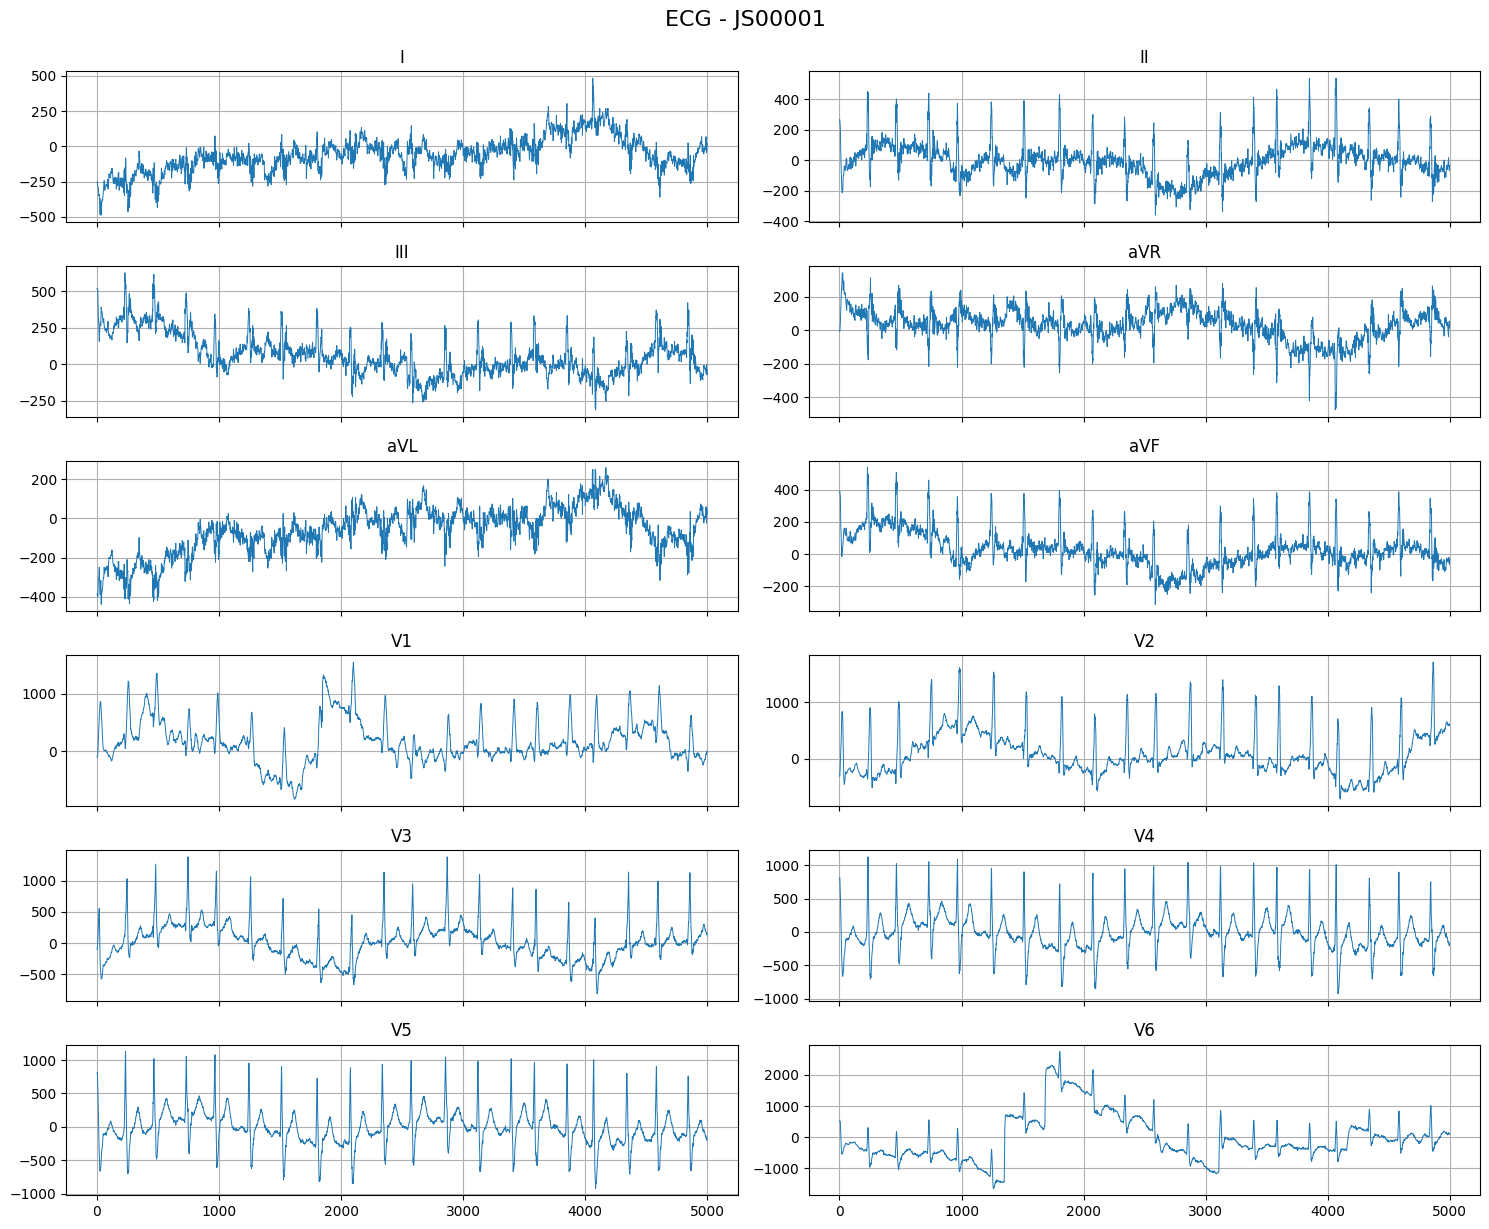

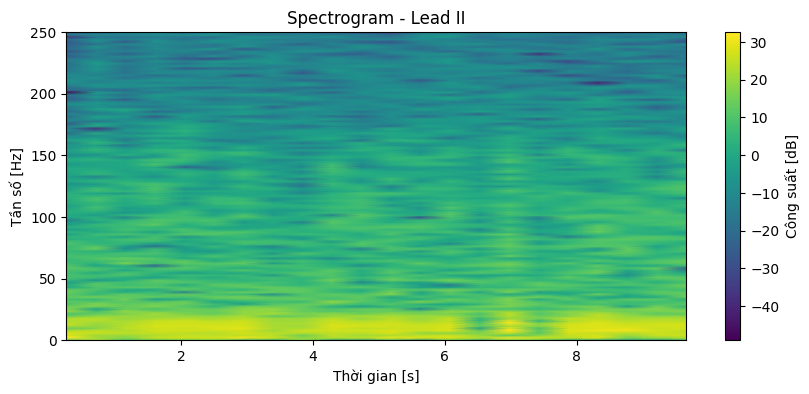

In [22]:
# Lấy bệnh nhân đầu tiên
sample_record = df_resolved.iloc[0]
mat_path = sample_record['file_path'].replace('.hea', '.mat')

print(f"Đang đọc file: {mat_path}")
signals = load_ecg_mat(mat_path)

# Vẽ tín hiệu 12 leads
plot_ecg_signals(signals, title=f"ECG - {sample_record['record_id']}")

# Vẽ spectrogram cho lead II
plot_spectrogram(signals, fs=500, lead_index=1)


# DENOISED

In [13]:
pip install pywavelets

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch


# --- 1. Load dữ liệu .mat ---
def load_ecg_mat(mat_file):
    """Đọc file .mat chứa ECG, trả về signals shape (12, N)"""
    mat = scipy.io.loadmat(mat_file)
    signals = mat['val']  # 12 x N
    return signals.astype(float)


# --- 2. Bộ lọc thông dải (0.5–40Hz) ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [lowcut / ny, highcut / ny], btype='band')
    return b, a

def apply_bandpass(sig, fs, lowcut=0.5, highcut=40.0, order=4):
    """Lọc giữ lại tần số sinh lý ECG (0.5–40Hz)"""
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, sig)


# --- 3. Bộ lọc Notch để loại nhiễu điện lưới 50Hz ---
def apply_notch(sig, fs, notch_freq=50.0, quality=30.0):
    """Loại nhiễu điện 50Hz (VN/EU powerline)"""
    b, a = iirnotch(notch_freq / (fs / 2), quality)
    return filtfilt(b, a, sig)


# --- 4. Chuyển đổi sang mV ---
def normalize_to_mV(sig, gain=1000):
    """Chuyển đổi từ đơn vị raw ADC sang mV"""
    return sig / gain


# --- 5. Lọc nhiễu 1 lead ---
def denoise_ecg_lead(sig, fs):
    """Pipeline lọc nhiễu cơ bản cho 1 lead ECG"""
    x = apply_notch(sig, fs, notch_freq=50.0, quality=30.0)
    x = apply_bandpass(x, fs, lowcut=0.5, highcut=40.0, order=3)
    return x


# --- 6. Áp dụng cho toàn bộ 12 leads ---
def denoise_all_leads(signals, fs):
    """Lọc nhiễu toàn bộ 12-leads ECG"""
    denoised = np.zeros_like(signals, dtype=float)
    for i in range(signals.shape[0]):
        denoised[i, :] = denoise_ecg_lead(signals[i, :], fs)
    return denoised

In [25]:
# Load dữ liệu
signals = load_ecg_mat(mat_path)  # shape (12, N)
fs = 500

# Chuẩn hóa sang mV
raw_mV = normalize_to_mV(signals, gain=1000)

# Lọc nhiễu
denoised = denoise_all_leads(raw_mV, fs)

# Hàm vẽ so sánh
def plot_compare(original, denoised, lead_idx=0, t=None, fs=500):
    plt.figure(figsize=(12,4))
    if t is None:
        t = np.arange(original.shape[1]) / fs
    plt.plot(t, original[lead_idx], label='Raw (mV)', linewidth=0.8)
    plt.plot(t, denoised[lead_idx], label='Denoised (mV)', linewidth=0.8)
    plt.legend()
    plt.title(f'Lead {lead_idx}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.show()

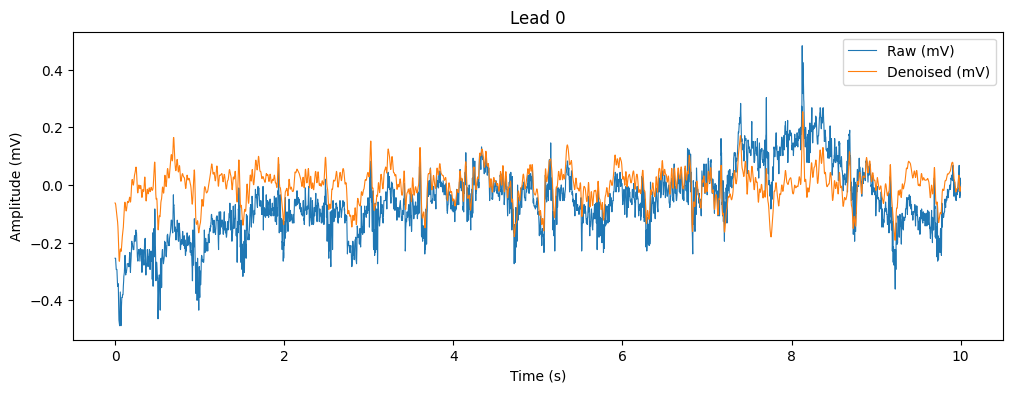

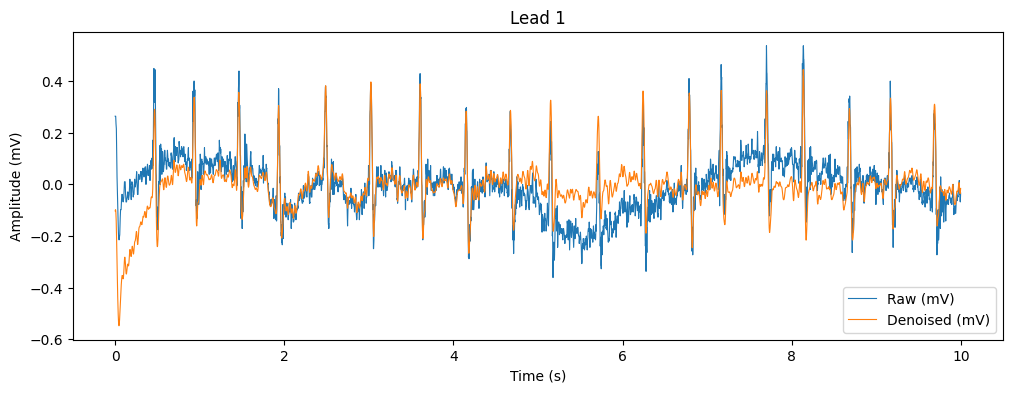

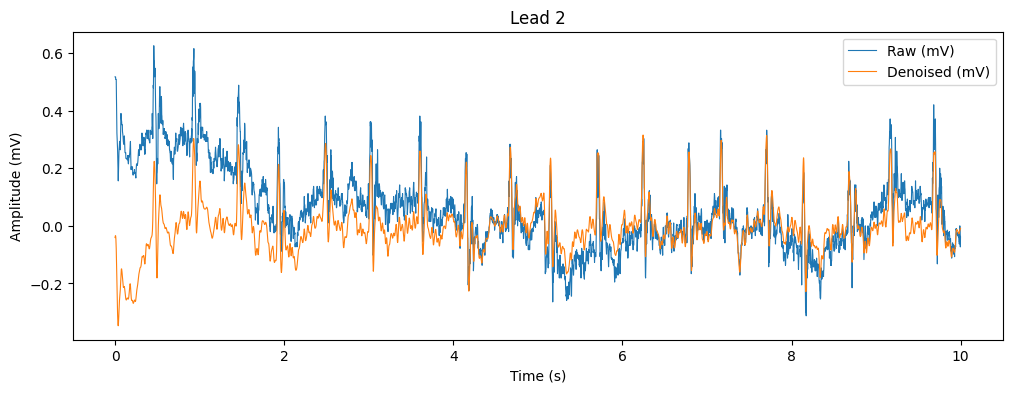

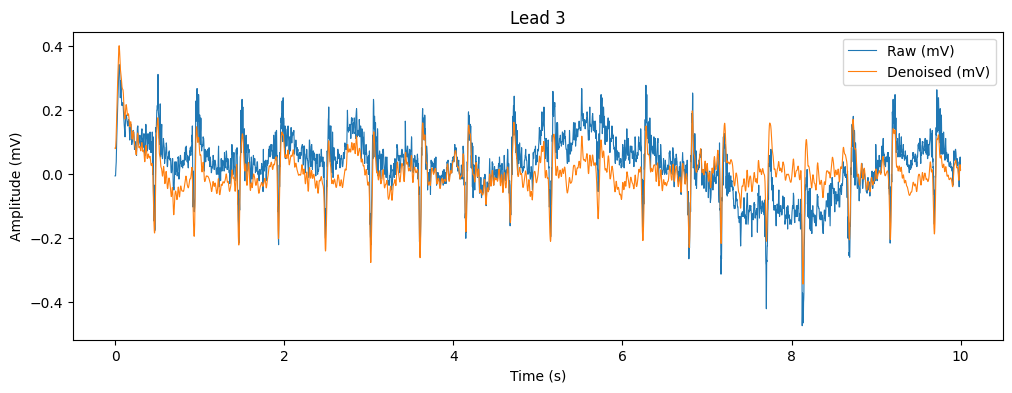

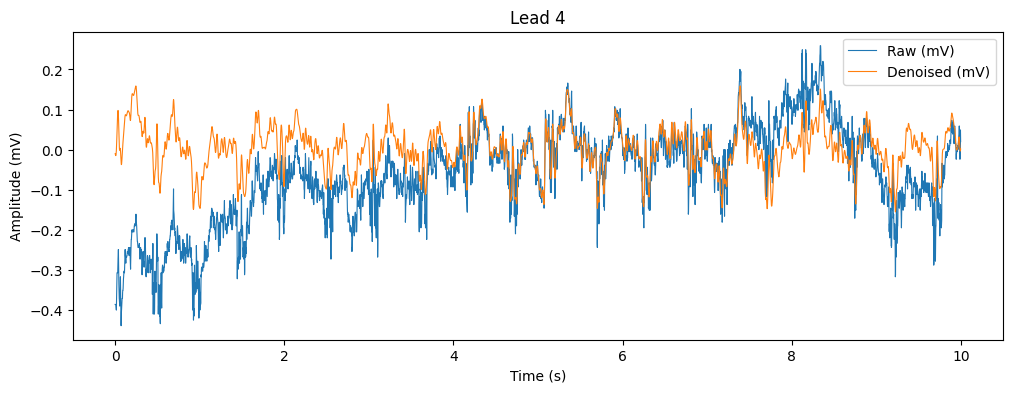

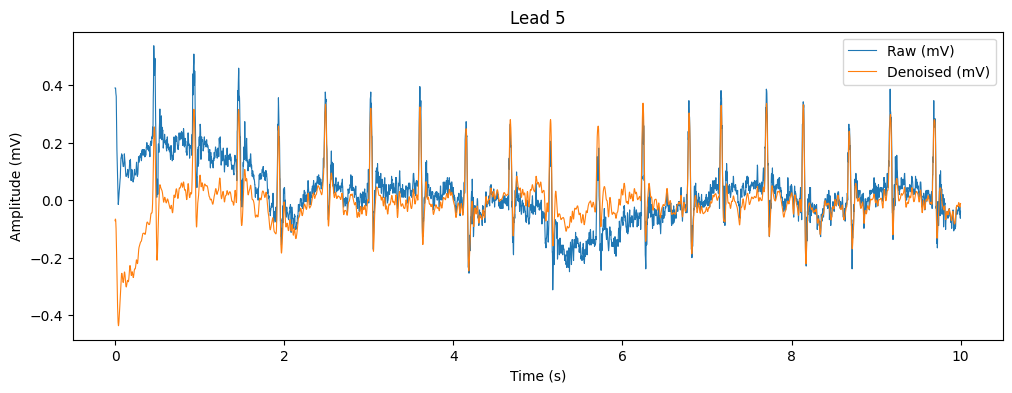

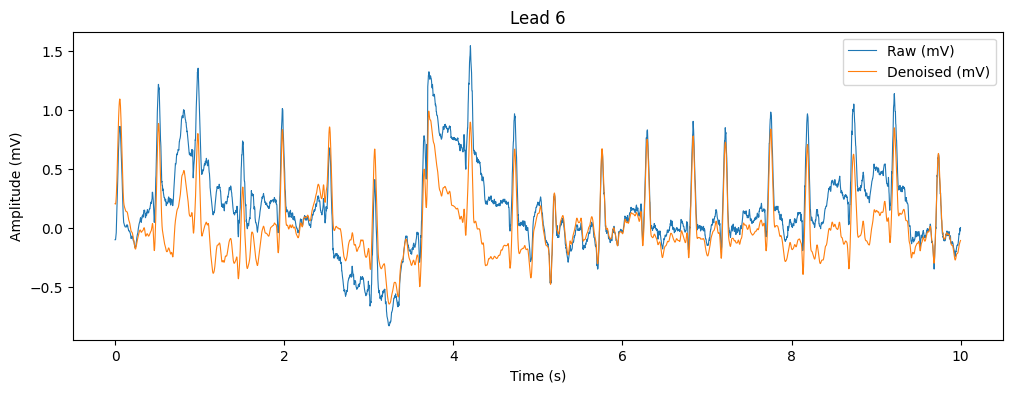

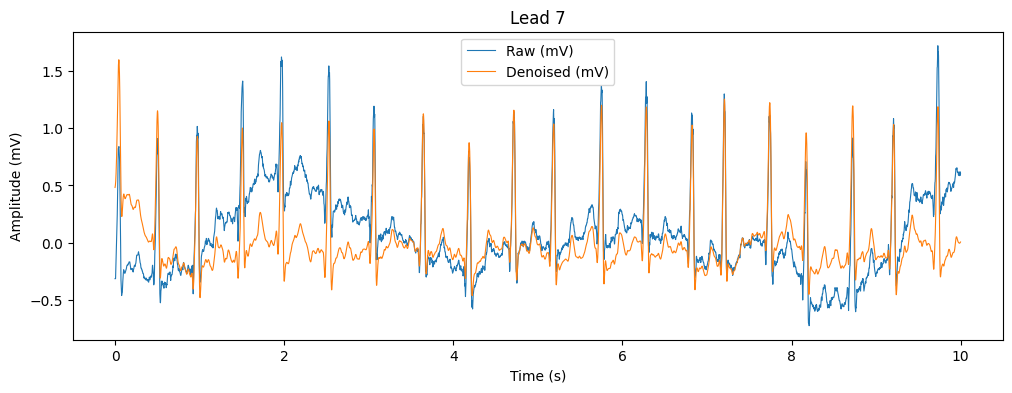

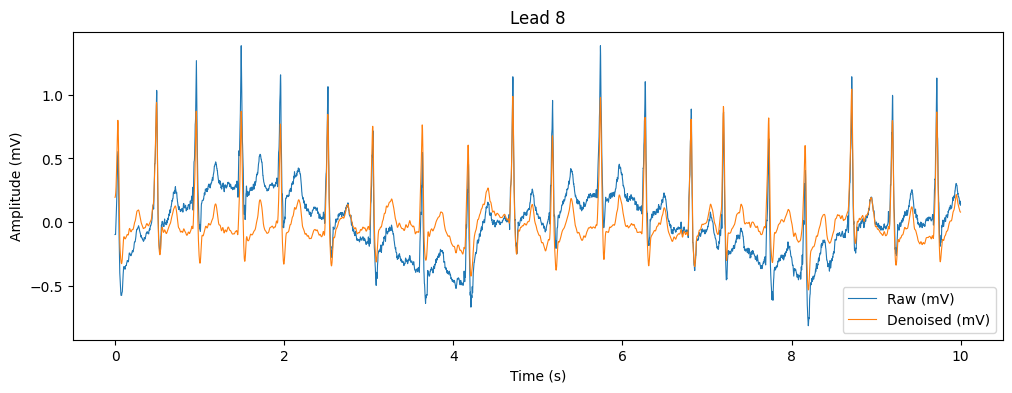

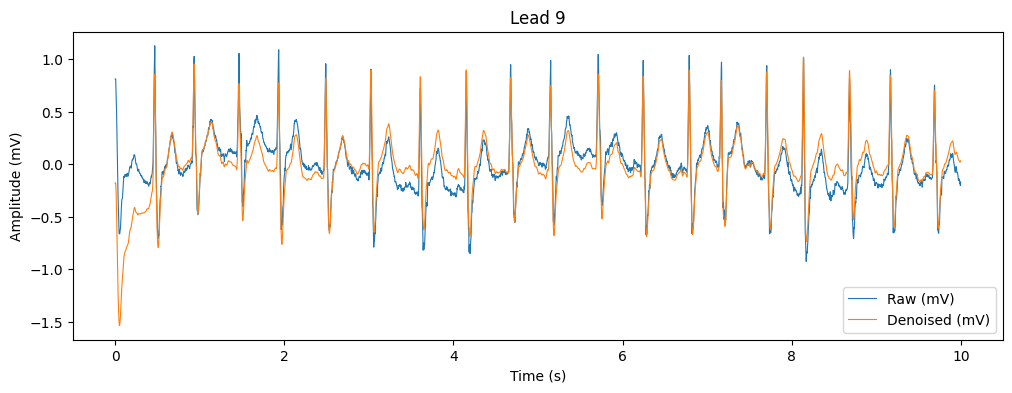

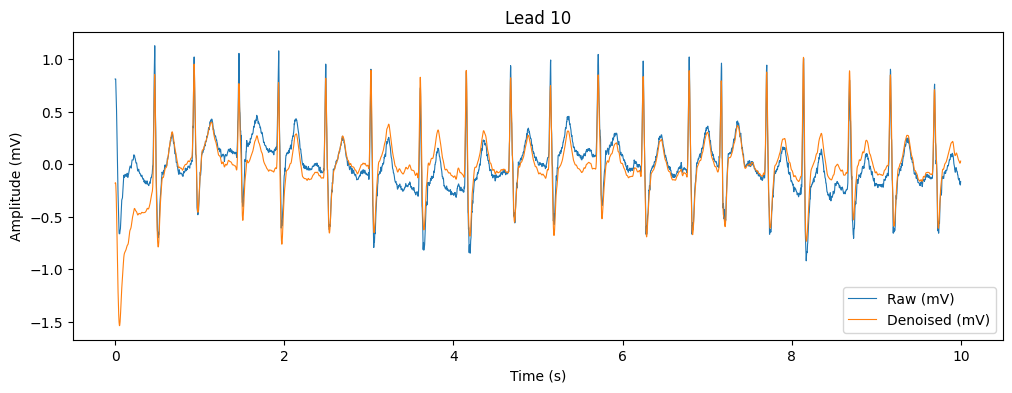

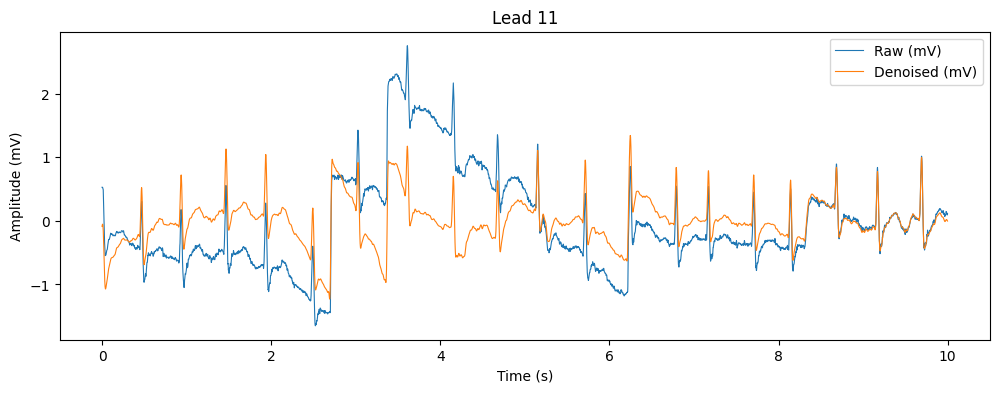

In [26]:
# hiển thị thử
for i in range(signals.shape[0]):
    plot_compare(raw_mV, denoised, lead_idx=i, fs=fs)

In [27]:
import numpy as np
from scipy.stats import pearsonr

def evaluate_denoising(original, denoised):
    """Tính độ lệch trước và sau lọc cho từng lead."""
    metrics = []
    for i in range(original.shape[0]):
        x, y = original[i], denoised[i]

        mae = np.mean(np.abs(x - y))
        rmse = np.sqrt(np.mean((x - y)**2))
        corr, _ = pearsonr(x, y)

        metrics.append({
            "lead": i,
            "MAE": mae,
            "RMSE": rmse,
            "Corr": corr
        })
    return metrics

# Gọi và hiển thị
metrics = evaluate_denoising(raw_mV, denoised)
for m in metrics:
    print(f"Lead {m['lead']:2d} | MAE={m['MAE']:.6f} | RMSE={m['RMSE']:.6f} | Corr={m['Corr']:.4f}")

Lead  0 | MAE=0.096794 | RMSE=0.115380 | Corr=0.5727
Lead  1 | MAE=0.063598 | RMSE=0.086738 | Corr=0.6724
Lead  2 | MAE=0.098272 | RMSE=0.144900 | Corr=0.4300
Lead  3 | MAE=0.062576 | RMSE=0.072369 | Corr=0.6955
Lead  4 | MAE=0.088984 | RMSE=0.124130 | Corr=0.4276
Lead  5 | MAE=0.070100 | RMSE=0.104201 | Corr=0.5399
Lead  6 | MAE=0.222579 | RMSE=0.279603 | Corr=0.7885
Lead  7 | MAE=0.230950 | RMSE=0.295842 | Corr=0.6738
Lead  8 | MAE=0.180636 | RMSE=0.205941 | Corr=0.6975
Lead  9 | MAE=0.113406 | RMSE=0.164229 | Corr=0.8241
Lead 10 | MAE=0.113394 | RMSE=0.164083 | Corr=0.8240
Lead 11 | MAE=0.495382 | RMSE=0.651573 | Corr=0.5070


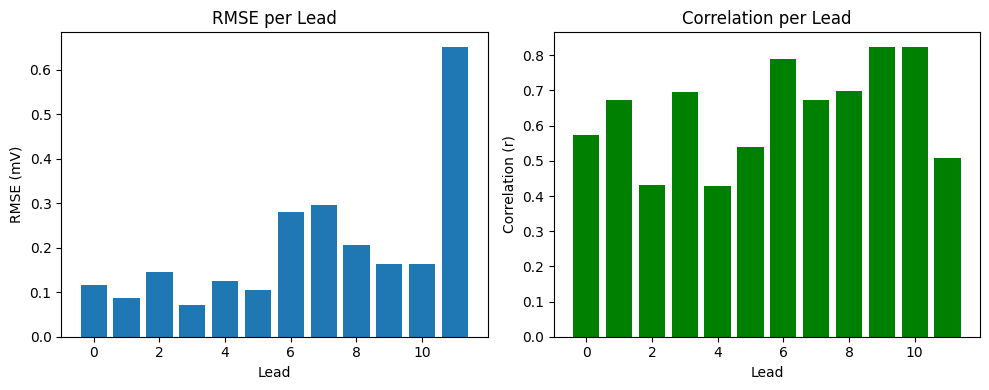

In [28]:
import matplotlib.pyplot as plt

leads = [m['lead'] for m in metrics]
rmses = [m['RMSE'] for m in metrics]
corrs = [m['Corr'] for m in metrics]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(leads, rmses)
plt.title("RMSE per Lead")
plt.xlabel("Lead")
plt.ylabel("RMSE (mV)")

plt.subplot(1,2,2)
plt.bar(leads, corrs, color='green')
plt.title("Correlation per Lead")
plt.xlabel("Lead")
plt.ylabel("Correlation (r)")

plt.tight_layout()
plt.show()

> **CODE CŨ**

# SPLIT TRAIN/VAL/TEST AND SAVE AS .NPY

In [14]:
pip install wfdb scikit-learn torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import torch

In [16]:
import pandas as pd
import numpy as np

# Danh sách top 8 SNOMED CT phổ biến nhất 
top_10_codes = ["426177001","426783006","164890007","427084000",
                "427393009","164889003","429622005","39732003"]

# Tạo cột multi-hot cho từng bệnh nhân
for code in top_10_codes:
    df_resolved[code] = df_resolved['diagnosis_codes'].apply(lambda x: 1 if code in x.split(',') else 0) # sd bảng dữ liệu đã sửa

# Lấy X, y
X_paths = df_resolved['file_path'].values  # danh sách file .mat
y = df_resolved[top_10_codes].values      # shape: (num_samples, 10)

print(f"Shape y: {y.shape}")  # (45152, 10)
print(f"Ví dụ nhãn 1 bệnh nhân: {y[0]}")

Shape y: (44203, 8)
Ví dụ nhãn 1 bệnh nhân: [0 0 0 0 0 1 0 0]


> **NEW**

> sig_z = (sig_denoised - sig_denoised.mean(axis=1, keepdims=True)) / \
        (sig_denoised.std(axis=1, keepdims=True) + 1e-8)
> - axis=1 = tính theo thời gian (mỗi hàng là 1 lead)
> - mean(axis=1, keepdims=True) = giá trị trung bình từng lead
> - std(axis=1, keepdims=True) = độ lệch chuẩn từng lead
> - 1e-8 = tránh chia cho 0 nếu tín hiệu phẳng.
> - => mỗi lead có mean ≈ 0, có std ≈ 1 => mô hình dễ học hơn => dữ liệu nằm trong thang đo đồng nhất.

In [17]:
save_dir = "processed_ecg_omaigah"

In [18]:
all_files = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith(".npy")]
train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=2/3, random_state=42)

print(f"Số file train: {len(train_files)}, val: {len(val_files)}, test: {len(test_files)}")

Số file train: 30942, val: 4420, test: 8841


# TRAIN DATASET WITH 1D-CNN

In [19]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [26]:
def get_index_from_filename(path):
    fname = os.path.basename(path)
    idx = int(fname.replace("record_", "").replace(".npy", ""))
    return idx

# Map y cho từng split
y_train = np.array([y[get_index_from_filename(f)] for f in train_files])
y_val   = np.array([y[get_index_from_filename(f)] for f in val_files])
y_test  = np.array([y[get_index_from_filename(f)] for f in test_files])

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (30942, 8)
y_val shape: (4420, 8)
y_test shape: (8841, 8)


In [27]:
import numpy as np
import torch
from torch.utils.data import Dataset

class ECGDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load tín hiệu ECG
        signal = np.load(self.file_paths[idx]).astype(np.float32)  # shape (12, N)

        # An toàn: xử lý NaN/Inf
        signal = np.nan_to_num(signal, nan=0.0, posinf=0.0, neginf=0.0)

        # Nếu bật augment thì thực hiện biến đổi
        if self.augment:
            signal = self.augment_signal(signal)

        # Convert sang Tensor
        signal = torch.tensor(signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return signal, label

    def augment_signal(self, sig):
        """Tạo các biến thể dữ liệu ngẫu nhiên để tăng độ đa dạng"""
        # Dịch trái/phải (temporal shift)
        shift = np.random.randint(-50, 50)
        sig = np.roll(sig, shift, axis=1)

        # Thêm nhiễu Gaussian nhẹ
        noise = np.random.normal(0, 0.01, sig.shape)
        sig += noise.astype(np.float32)

        # Scale biên độ
        scale = np.random.uniform(0.9, 1.1)
        sig *= scale

        # Clip lại để tránh overflow
        sig = np.clip(sig, -5, 5)
        return sig

In [28]:
from torch.utils.data import Dataset, DataLoader

# Dataset
train_dataset = ECGDataset(train_files, y_train, augment=True)  # bật augment
val_dataset   = ECGDataset(val_files, y_val, augment=False)
test_dataset  = ECGDataset(test_files, y_test, augment=False)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Số batch train: {len(train_loader)}")
print(f"Số batch val: {len(val_loader)}")
print(f"Số batch test: {len(test_loader)}")

Số batch train: 967
Số batch val: 139
Số batch test: 277


In [52]:
# Lấy 5 phần tử đầu tiên trong tập test
for i in range(5):
    x, y = test_dataset[i]
    print(f" File {i+1}:")
    print(f"  Dữ liệu ECG shape: {x.shape}")
    print(f"  Nhãn: {y}")
    print("-" * 40)

 File 1:
  Dữ liệu ECG shape: torch.Size([12, 5000])
  Nhãn: tensor([0., 0., 0., 1., 0., 0., 0., 0.])
----------------------------------------
 File 2:
  Dữ liệu ECG shape: torch.Size([12, 5000])
  Nhãn: tensor([0., 0., 1., 0., 0., 0., 0., 0.])
----------------------------------------
 File 3:
  Dữ liệu ECG shape: torch.Size([12, 5000])
  Nhãn: tensor([1., 0., 0., 0., 0., 0., 0., 0.])
----------------------------------------
 File 4:
  Dữ liệu ECG shape: torch.Size([12, 5000])
  Nhãn: tensor([1., 0., 0., 0., 0., 0., 0., 0.])
----------------------------------------
 File 5:
  Dữ liệu ECG shape: torch.Size([12, 5000])
  Nhãn: tensor([0., 0., 1., 0., 0., 0., 0., 0.])
----------------------------------------


In [53]:
import os

for i in range(5):
    file_path = test_files[i]
    file_name = os.path.basename(file_path)
    print(f"{i+1}. {file_name}")

1. record_40962.npy
2. record_15001.npy
3. record_29668.npy
4. record_31671.npy
5. record_16929.npy


In [20]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

> - **USING ATTENTION TO FOCUS FEATURES**

In [25]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, feat_dim)
        weights = self.attn(x)  # (batch, seq_len, 1)
        weights = F.softmax(weights, dim=1)
        context = torch.sum(weights * x, dim=1)  # (batch, feat_dim)
        return context, weights

> sử dụng thêm attention để học trọng số quan trọng của từng “thời điểm” (time step) trong chuỗi đặc trưng đầu vào,
tập trung hơn vào những đoạn tín hiệu chứa thông tin bệnh lý, thay vì coi mọi điểm thời gian đều quan trọng như nhau.
> - **weights = self.attn(x)**: tính điểm attention cho mỗi time step, kết quả trả về batch, seq_len (số điểm thời gian) => mỗi bước thời gian có 1 điểm trọng số
> -  **weights = F.softmax(weights, dim=1)**: chuẩn hóa thành xác suất với softmax [0,1]
> -  **context = torch.sum(weights * x, dim=1)**: lấy trung bình có trọng số, tổng hợp lại thành một vector duy nhất thể hiện nơi mô hình chú ý nhất

> - **CREATE 1D CNN TRAINING MODEL WITH ATTENTION**

In [29]:
class CNN1DAttention(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN1DAttention, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)

        self.attention = Attention(64)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, 12, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # đổi shape để đưa qua attention
        x = x.permute(0, 2, 1)  # (batch, seq_len, feat_dim=64)
        x, _ = self.attention(x)

        out = self.fc(x)
        return out

> - **CREATE RESNET 1DCNN TRAINING MODEL WITH ATTENTION**

> **RESNETV1**

In [30]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels,
                                      kernel_size=1, stride=stride)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet1DAttention(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet1DAttention, self).__init__()
        self.layer1 = BasicBlock1D(12, 64, stride=2)
        self.layer2 = BasicBlock1D(64, 128, stride=2)
        self.layer3 = BasicBlock1D(128, 128, stride=2)

        self.attention = Attention(128)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.permute(0, 2, 1)  # (batch, seq_len, feat_dim=128)
        x, _ = self.attention(x)

        out = self.fc(x)
        return out

> **RESNETV2**

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Giữ nguyên BasicBlock1D ---
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels,
                                      kernel_size=1, stride=stride)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# --- Mô hình cải tiến ---
class ResNet1DAttentionV2(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet1DAttentionV2, self).__init__()

        # Thêm 1 block đầu tiên để trích xuất đặc trưng sớm
        self.layer1 = BasicBlock1D(12, 64, stride=2)
        self.layer2 = BasicBlock1D(64, 128, stride=2)
        self.layer3 = BasicBlock1D(128, 256, stride=2)
        self.layer4 = BasicBlock1D(256, 256, stride=2)  # thêm tầng sâu hơn

        # Attention làm việc trên feature 256 chiều
        self.attention = Attention(256)

        # Fully connected
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)  # -> (B,64,L/2)
        x = self.layer2(x)  # -> (B,128,L/4)
        x = self.layer3(x)  # -> (B,256,L/8)
        x = self.layer4(x)  # -> (B,256,L/16)

        # Attention (chuyển sang batch, seq_len, feat_dim)
        x = x.permute(0, 2, 1)
        x, attn_weights = self.attention(x)

        # FC
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out


> - **TRAIN MODEL**

In [31]:
import torch

# --- Tính pos_weight theo công thức: (số mẫu âm) / (số mẫu dương) ---
num_samples, num_classes = y_train.shape
positive_counts = y_train.sum(axis=0)
negative_counts = num_samples - positive_counts

pos_weight = negative_counts / (positive_counts + 1e-6)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

print("pos_weight:", pos_weight)

pos_weight: tensor([ 1.6660,  4.5812,  4.5263,  5.1223, 16.1045, 24.3831, 25.8128, 28.1356],
       device='cuda:0')


In [32]:
def train_model(model, train_loader, val_loader, num_epochs=20, patience=5, lr=1e-3, device="cuda"):
    import copy
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #thêm vào pos_weight=pos_weight

    best_val_loss = float("inf")
    best_state = copy.deepcopy(model.state_dict())   # luôn có state_dict hợp lệ
    patience_counter = 0

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        total_loss = 0
        for signals, labels in train_loader:
            signals, labels = signals.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # ---- Validate ----
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for signals, labels in val_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs = model(signals)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(model.state_dict())  # copy hẳn
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_state)
    return model


- **CROSS VALIDATION**

In [22]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import torch

- gộp dataset để huấn luyện, lấy tập train và val

In [32]:
# Gộp train + val để cross-validation
combined_files = train_files + val_files
combined_labels = np.concatenate([y_train, y_val], axis=0)
combined_dataset = ECGDataset(combined_files, combined_labels, augment=True)

In [33]:
def cross_validate_model(model_class, dataset, num_classes=8, k_folds=5, batch_size=32,
                         num_epochs=20, lr=1e-3, device="cuda"):
    from torch.utils.data import DataLoader, Subset
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    from sklearn.model_selection import KFold
    import numpy as np
    import torch
    import os

    os.makedirs("saved_models", exist_ok=True)
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_results = []
    best_f1 = 0.0
    best_model_path = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):
        print(f"\n===== Fold {fold+1}/{k_folds} =====")

        # --- Tạo subset cho fold hiện tại ---
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # --- Khởi tạo mô hình ---
        model = model_class(num_classes=num_classes)
        model = train_model(model, train_loader, val_loader,
                            num_epochs=num_epochs, lr=lr, device=device)

        # --- Đánh giá trên tập validation ---
        model.eval()
        preds, y_true = [], []
        with torch.no_grad():
            for signals, labels in val_loader:
                signals = signals.to(device)
                outputs = model(signals)
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds.append(probs)
                y_true.append(labels.numpy())

        preds = np.vstack(preds)
        y_true = np.vstack(y_true)
        preds_bin = (preds > 0.5).astype(int)

        # --- Tính metrics ---
        acc = accuracy_score(y_true, preds_bin)
        prec = precision_score(y_true, preds_bin, average="macro", zero_division=0)
        rec = recall_score(y_true, preds_bin, average="macro", zero_division=0)
        f1 = f1_score(y_true, preds_bin, average="macro", zero_division=0)

        print(f"Fold {fold+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        fold_results.append((acc, prec, rec, f1))

        # --- Lưu mô hình của fold ---
        model_path = f"saved_models/model_fold{fold+1}.pth"
        torch.save(model.state_dict(), model_path)

        # --- Kiểm tra xem có phải mô hình tốt nhất không ---
        if f1 > best_f1:
            best_f1 = f1
            best_model_path = model_path

        # --- In báo cáo chi tiết ---
        print("\nClassification Report:")
        print(classification_report(y_true, preds_bin, zero_division=0))

    # --- Trung bình kết quả các fold ---
    accs, precs, recs, f1s = zip(*fold_results)
    print("\n===== Kết quả trung bình qua các fold =====")
    print(f"Accuracy:  {np.mean(accs):.4f}")
    print(f"Precision: {np.mean(precs):.4f}")
    print(f"Recall:    {np.mean(recs):.4f}")
    print(f"F1-score:  {np.mean(f1s):.4f}")

    print(f"\nMô hình tốt nhất: Fold có F1 = {best_f1:.4f}")
    print(f"Đã lưu tại: {best_model_path}")

    # --- Load lại mô hình tốt nhất ---
    best_model = model_class(num_classes=num_classes)
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.to(device)
    best_model.eval()

    return {
        "fold_results": fold_results,
        "best_model": best_model,
        "best_model_path": best_model_path
    }

> - **EVALUATE**

In [33]:
def evaluate_model(model, test_loader, y_test, device="cuda"):
    model = model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for signals, _ in test_loader:
            signals = signals.to(device)
            outputs = model(signals)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds.append(probs)
    preds = np.vstack(preds)
    preds_bin = (preds > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, preds_bin, target_names=[str(c) for c in range(y_test.shape[1])]))

    print("\nConfusion Matrices:")
    cms = multilabel_confusion_matrix(y_test, preds_bin)
    for i, cm in enumerate(cms):
        print(f"Label {i}:\n{cm}\n")

    return preds_bin, preds, cms

> **TRAINING WITH BASIC 1D CNN**

In [23]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model 1: CNN1DAttention
cnn_model = CNN1DAttention(num_classes=8)
cnn_model = train_model(cnn_model, train_loader, val_loader, device=device)

print("\n=== Đánh giá CNN + Attention ===")
evaluate_model(cnn_model, test_loader, y_test, device=device)

Epoch 1: train_loss=0.2690, val_loss=0.2772
Epoch 2: train_loss=0.2282, val_loss=0.2873
Epoch 3: train_loss=0.2159, val_loss=0.3002
Epoch 4: train_loss=0.2107, val_loss=0.3066
Epoch 5: train_loss=0.2073, val_loss=0.3141
Epoch 6: train_loss=0.2028, val_loss=0.2988
Early stopping!

=== Đánh giá CNN + Attention ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.47      0.60      3267
           1       0.60      0.00      0.00      1610
           2       0.57      0.39      0.46      1630
           3       0.77      0.29      0.42      1469
           4       0.62      0.07      0.12       482
           5       0.00      0.00      0.00       376
           6       0.00      0.00      0.00       336
           7       0.64      0.16      0.26       323

   micro avg       0.73      0.28      0.41      9493
   macro avg       0.50      0.17      0.23      9493
weighted avg       0.66      0.28      0.37      9493
 samples avg

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(8841, 8))

- **0:| 426177001 | SB |** Sinus Bradycardia | Nhịp chậm xoang |
- **1:| 426783006 | SR |** Sinus Rhythm | Nhịp xoang bình thường |
- **2:| 164890007 | AF |** Atrial Flutter | Cuồng nhĩ |
- **3:| 427084000 | ST |** ST Elevation | Chênh lên đoạn ST |
- **4:| 427393009 | SA |** Sinus Arrhythmia | Loạn nhịp xoang |
- **5:| 164889003 | AFIB |** Atrial Fibrillation (alternate) | Rung nhĩ |
- **6:| 429622005 | STDD |** ST drop down | Chênh xuống đoạn ST |
- **7:| 39732003 | ALS |** Axis left shift | Trục điện tim lệch trái |

In [51]:
torch.save(cnn_model.state_dict(), "cnn_attention_resampling2.pth")

> **TRAINING WITH RESNET 1D CNN**

In [50]:
# Model 2: ResNet1DAttention
resnet_model = ResNet1DAttention(num_classes=8)
resnet_model = train_model(resnet_model, train_loader, val_loader, device=device)

print("\n=== Đánh giá ResNet1D + Attention ===")
evaluate_model(resnet_model, test_loader, y_test, device=device)

Epoch 1: train_loss=0.7716, val_loss=0.6626
Epoch 2: train_loss=0.6356, val_loss=0.6229
Epoch 3: train_loss=0.5833, val_loss=0.5692
Epoch 4: train_loss=0.5521, val_loss=0.5441
Epoch 5: train_loss=0.5329, val_loss=0.5414
Epoch 6: train_loss=0.5156, val_loss=0.5194
Epoch 7: train_loss=0.5030, val_loss=0.5150
Epoch 8: train_loss=0.4925, val_loss=0.5103
Epoch 9: train_loss=0.4818, val_loss=0.5010
Epoch 10: train_loss=0.4699, val_loss=0.4973
Epoch 11: train_loss=0.4642, val_loss=0.5086
Epoch 12: train_loss=0.4524, val_loss=0.5111
Epoch 13: train_loss=0.4481, val_loss=0.5137
Epoch 14: train_loss=0.4365, val_loss=0.4794
Epoch 15: train_loss=0.4309, val_loss=0.5073
Epoch 16: train_loss=0.4240, val_loss=0.4951
Epoch 17: train_loss=0.4185, val_loss=0.4881
Epoch 18: train_loss=0.4100, val_loss=0.5153
Epoch 19: train_loss=0.4053, val_loss=0.4960
Early stopping!

=== Đánh giá ResNet1D + Attention ===

Classification Report:
              precision    recall  f1-score   support

           0       0

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

(array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], shape=(8841, 8)),
 array([[1.5610823e-04, 9.8735446e-01, 6.5781865e-07, ..., 4.5056947e-08,
         4.1301735e-04, 2.3518077e-01],
        [2.3506116e-04, 1.0270028e-01, 9.6463823e-01, ..., 8.7136406e-01,
         2.2837907e-02, 2.2615171e-05],
        [8.8897270e-01, 1.3268004e-01, 2.9483985e-02, ..., 3.0029129e-02,
         3.2778564e-01, 5.8969522e-06],
        ...,
        [2.7167036e-06, 8.4918952e-01, 1.5402648e-02, ..., 1.8871428e-03,
         1.0831101e-02, 4.3082872e-12],
        [9.7597086e-01, 1.7280336e-01, 3.4320951e-03, ..., 7.1105751e-04,
         4.0379170e-04, 1.1162059e-05],
        [9.8534113e-01, 8.9819394e-02, 1.6045475e-05, ..., 3.2420846e-06,
         2.7297993e-04, 4.4557869e-06]], shape=(8841, 8), dtype=float32),
 array([[[5232,  342],
         [ 111, 

- crossvalidation

In [45]:
results = cross_validate_model(
    model_class=ResNet1DAttention,
    dataset=combined_dataset,
    num_classes=8,
    k_folds=5,
    batch_size=32,
    num_epochs=20,
    lr=1e-3,
    device=device
)

best_model = results["best_model"]
print("Best model loaded from:", results["best_model_path"])


===== Fold 1/5 =====
Epoch 1: train_loss=0.7635, val_loss=0.6925
Epoch 2: train_loss=0.6309, val_loss=0.5989
Epoch 3: train_loss=0.5840, val_loss=0.6164
Epoch 4: train_loss=0.5666, val_loss=0.5624
Epoch 5: train_loss=0.5320, val_loss=0.5426
Epoch 6: train_loss=0.5178, val_loss=0.5298
Epoch 7: train_loss=0.5077, val_loss=0.5131
Epoch 8: train_loss=0.4947, val_loss=0.5191
Epoch 9: train_loss=0.4850, val_loss=0.5053
Epoch 10: train_loss=0.4767, val_loss=0.5145
Epoch 11: train_loss=0.4662, val_loss=0.5097
Epoch 12: train_loss=0.4603, val_loss=0.5018
Epoch 13: train_loss=0.4530, val_loss=0.4958
Epoch 14: train_loss=0.4449, val_loss=0.5049
Epoch 15: train_loss=0.4359, val_loss=0.4910
Epoch 16: train_loss=0.4278, val_loss=0.4976
Epoch 17: train_loss=0.4219, val_loss=0.4991
Epoch 18: train_loss=0.4166, val_loss=0.5108
Epoch 19: train_loss=0.4113, val_loss=0.4884
Epoch 20: train_loss=0.4013, val_loss=0.4947
Fold 1 - Accuracy: 0.3006, Precision: 0.4585, Recall: 0.8986, F1: 0.5719

Classificatio

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3884\2925616311.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_lo

In [46]:
print("\n=== Đánh giá mô hình tốt nhất trên TEST SET ===")
evaluate_model(best_model, test_loader, y_test, device=device)


=== Đánh giá mô hình tốt nhất trên TEST SET ===

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3267
           1       0.49      0.84      0.62      1610
           2       0.69      0.97      0.81      1630
           3       0.76      0.96      0.85      1469
           4       0.12      0.75      0.21       482
           5       0.19      0.93      0.31       376
           6       0.21      0.86      0.34       336
           7       0.44      0.95      0.61       323

   micro avg       0.51      0.91      0.65      9493
   macro avg       0.48      0.90      0.58      9493
weighted avg       0.67      0.91      0.75      9493
 samples avg       0.58      0.90      0.68      9493


Confusion Matrices:
Label 0:
[[5290  284]
 [ 237 3030]]

Label 1:
[[5830 1401]
 [ 259 1351]]

Label 2:
[[6515  696]
 [  46 1584]]

Label 3:
[[6930  442]
 [  57 1412]]

Label 4:
[[5770 2589]
 [ 119  363]]

Label 5:
[[6969 

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], shape=(8841, 8)),
 array([[2.13955482e-03, 3.97256762e-01, 5.49412762e-05, ...,
         2.17010820e-05, 6.27015810e-03, 4.99432802e-01],
        [2.57874577e-04, 5.81312440e-02, 9.55989182e-01, ...,
         8.65112185e-01, 4.86524403e-02, 1.19486094e-05],
        [6.43574893e-01, 6.95593297e-01, 2.29990911e-02, ...,
         4.81528193e-02, 1.29763484e-01, 8.00951852e-07],
        ...,
        [7.13861311e-07, 9.50966775e-01, 9.30533838e-03, ...,
         1.61958058e-04, 1.35016795e-02, 4.29697619e-13],
        [9.04220104e-01, 2.87376016e-01, 8.42265319e-03, ...,
         1.51311969e-02, 2.02161653e-04, 8.33075973e-08],
        [9.73021507e-01, 1.43225417e-01, 1.71998545e-04, ...,
         1.14592694e-04, 4.94138850e-03, 7.00758676e-07]],
       shape=(8841, 8), dtype=float3

In [47]:
torch.save(best_model.state_dict(), "resnet_attention_best_fold.pth")

> - **RELOAD MODEL AND FIND BEST THRESHOLD**

In [34]:
final_model = ResNet1DAttention(num_classes=8)
final_model.load_state_dict(torch.load("resnet_attention_best_fold.pth", map_location=device))
final_model.to(device)
final_model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7032\2876158776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("resnet_attention_best_

ResNet1DAttention(
  (layer1): BasicBlock1D(
    (conv1): Conv1d(12, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv1d(12, 64, kernel_size=(1,), stride=(2,))
  )
  (layer2): BasicBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv1d(64, 128, kernel_size=(1,), stride=(2,))
  )
  (layer3): BasicBlock1D(
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e

In [45]:
final_model = ResNet1DAttention(num_classes=8)
final_model.load_state_dict(torch.load("resnet_attention_resampling_posweight1.pth", map_location=device))
final_model.to(device)
final_model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7032\2594214582.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("resnet_attention_resam

ResNet1DAttention(
  (layer1): BasicBlock1D(
    (conv1): Conv1d(12, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv1d(12, 64, kernel_size=(1,), stride=(2,))
  )
  (layer2): BasicBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv1d(64, 128, kernel_size=(1,), stride=(2,))
  )
  (layer3): BasicBlock1D(
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e

In [46]:
import torch
import numpy as np

y_true = []
y_pred_proba = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = torch.sigmoid(final_model(X_batch))  # lấy xác suất (0–1)
        y_true.append(y_batch.cpu().numpy())
        y_pred_proba.append(outputs.cpu().numpy())

y_true = np.vstack(y_true)
y_pred_proba = np.vstack(y_pred_proba)

In [47]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.1, 0.9, 17)  # các ngưỡng từ 0.1 đến 0.9, bước 0.05
    best_thresh = []
    for i in range(y_true.shape[1]):  # chạy cho từng class
        best_t, best_f1 = 0.5, 0
        for t in thresholds:
            preds = (y_pred_proba[:, i] > t).astype(int)
            f1 = f1_score(y_true[:, i], preds)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

In [48]:
best_thresholds = find_best_threshold(y_true, y_pred_proba)
print("Best thresholds:", best_thresholds)

Best thresholds: [0.5  0.75 0.75 0.65 0.8  0.6  0.9  0.9 ]


In [49]:
from sklearn.metrics import classification_report

# Dự đoán theo từng ngưỡng
y_pred = np.zeros_like(y_pred_proba)
for i in range(y_pred_proba.shape[1]):
    y_pred[:, i] = (y_pred_proba[:, i] > best_thresholds[i]).astype(int)

# Báo cáo kết quả
print("\n=== Evaluation on TEST SET ===")
print(classification_report(y_true, y_pred, target_names=[f"Class_{i}" for i in range(y_pred.shape[1])]))


=== Evaluation on TEST SET ===
              precision    recall  f1-score   support

     Class_0       0.90      0.97      0.93      3267
     Class_1       0.62      0.71      0.66      1610
     Class_2       0.73      0.94      0.82      1630
     Class_3       0.87      0.90      0.89      1469
     Class_4       0.40      0.32      0.36       482
     Class_5       0.20      0.90      0.33       376
     Class_6       0.38      0.51      0.44       336
     Class_7       0.48      0.90      0.63       323

   micro avg       0.67      0.86      0.75      9493
   macro avg       0.57      0.77      0.63      9493
weighted avg       0.73      0.86      0.78      9493
 samples avg       0.72      0.85      0.76      9493



C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

# **GRAD CAM**

In [41]:
class_names = [
    "Sinus Bradycardia (SB)",
    "Sinus Rhythm (SR)",
    "Atrial Flutter (AF)",
    "ST Elevation (ST)",
    "Sinus Arrhythmia (SA)",
    "Atrial Fibrillation (AFIB)",
    "ST Depression (STDD)",
    "Axis Left Shift (ALS)"
]

In [43]:
lead_names = ["I", "II", "III", "aVR", "aVL", "aVF",
              "V1", "V2", "V3", "V4", "V5", "V6"]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7032\4057873534.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_attention_best_fold.

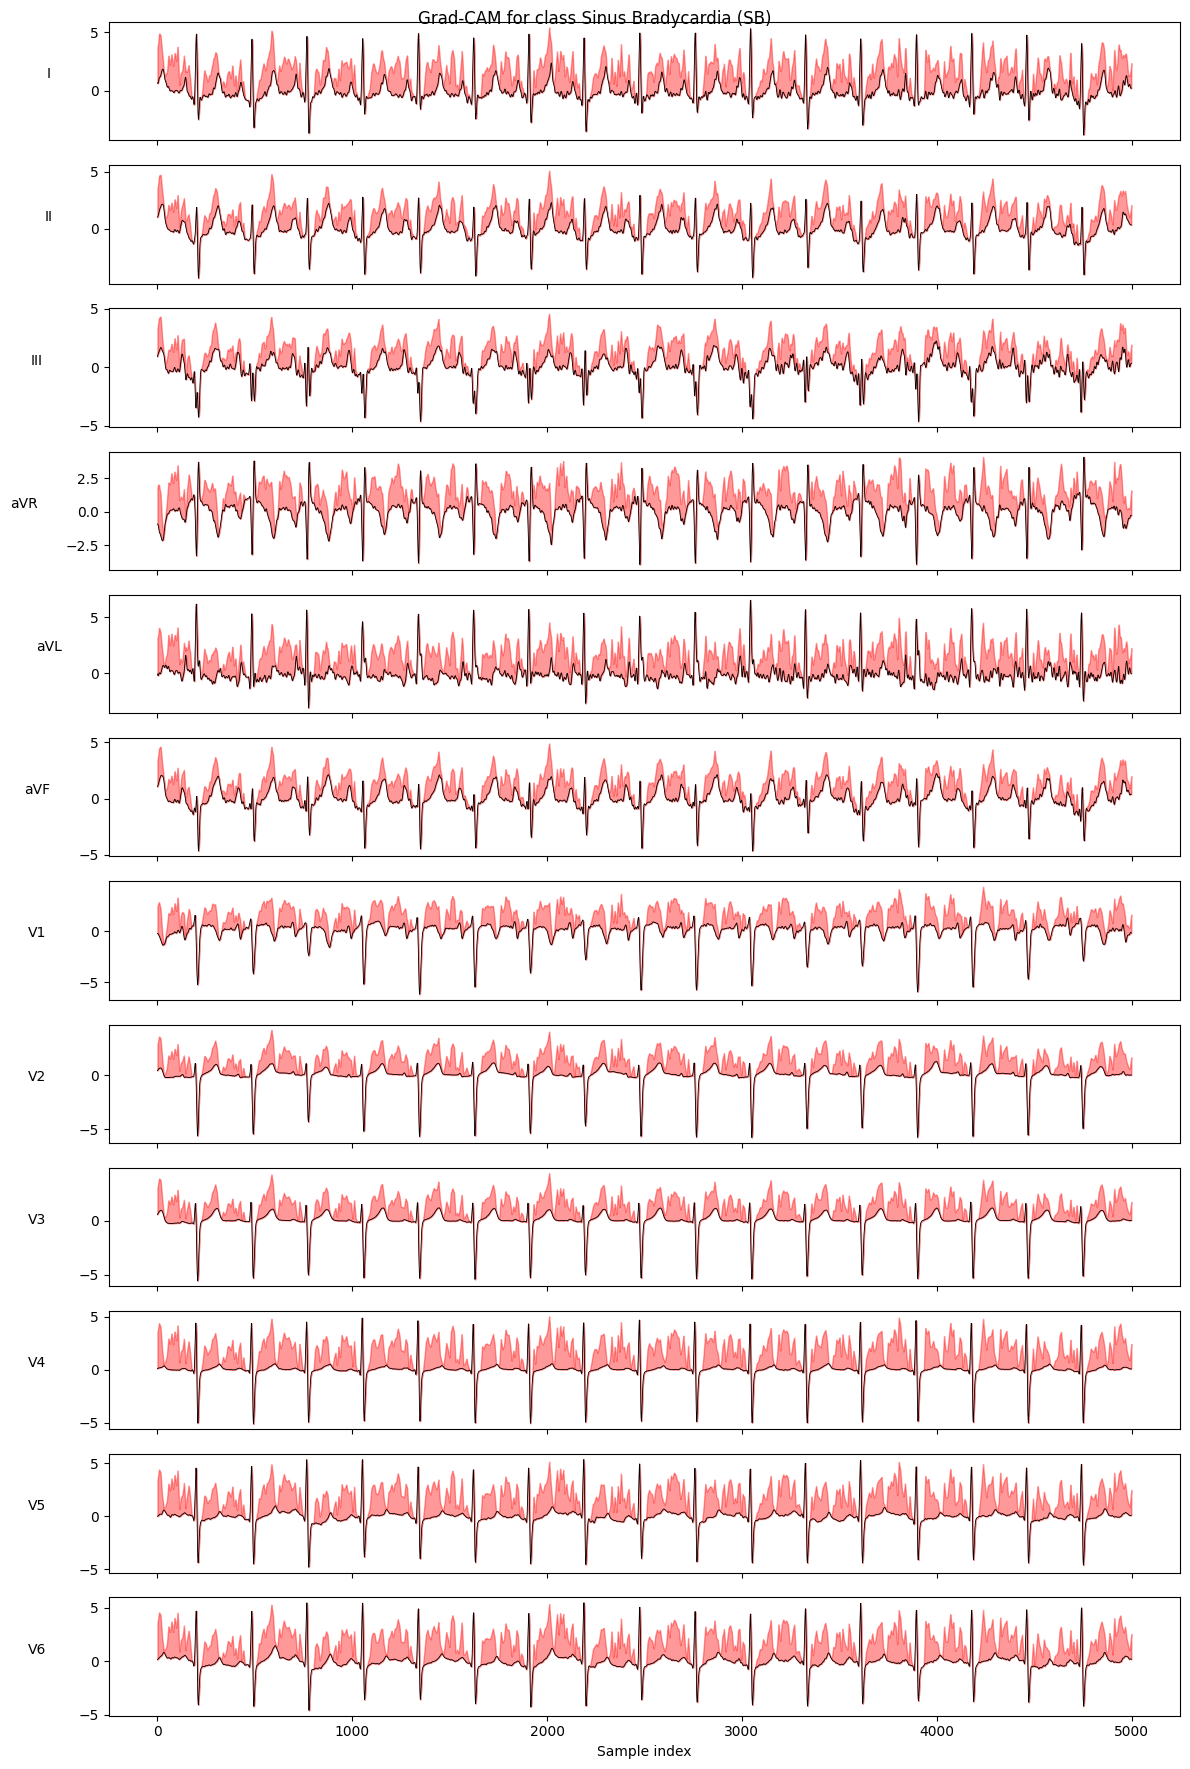

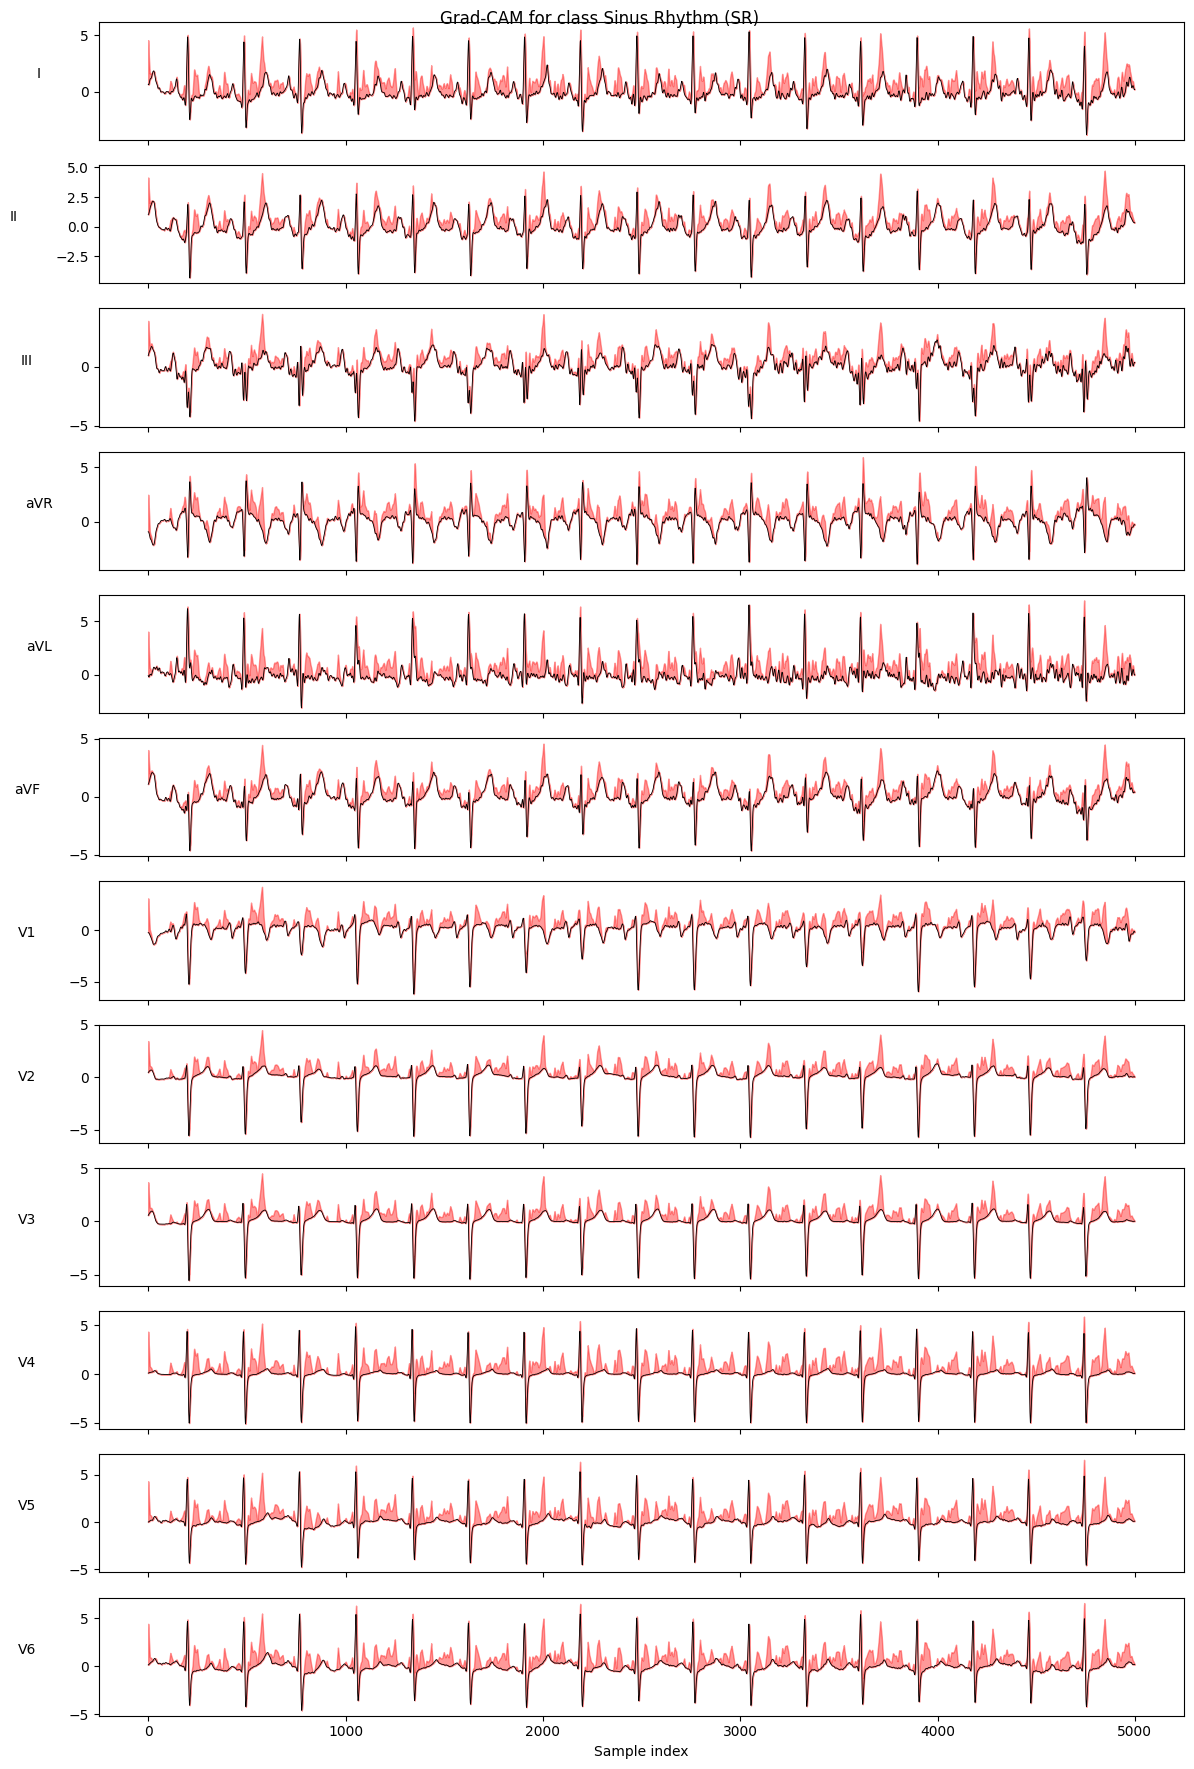

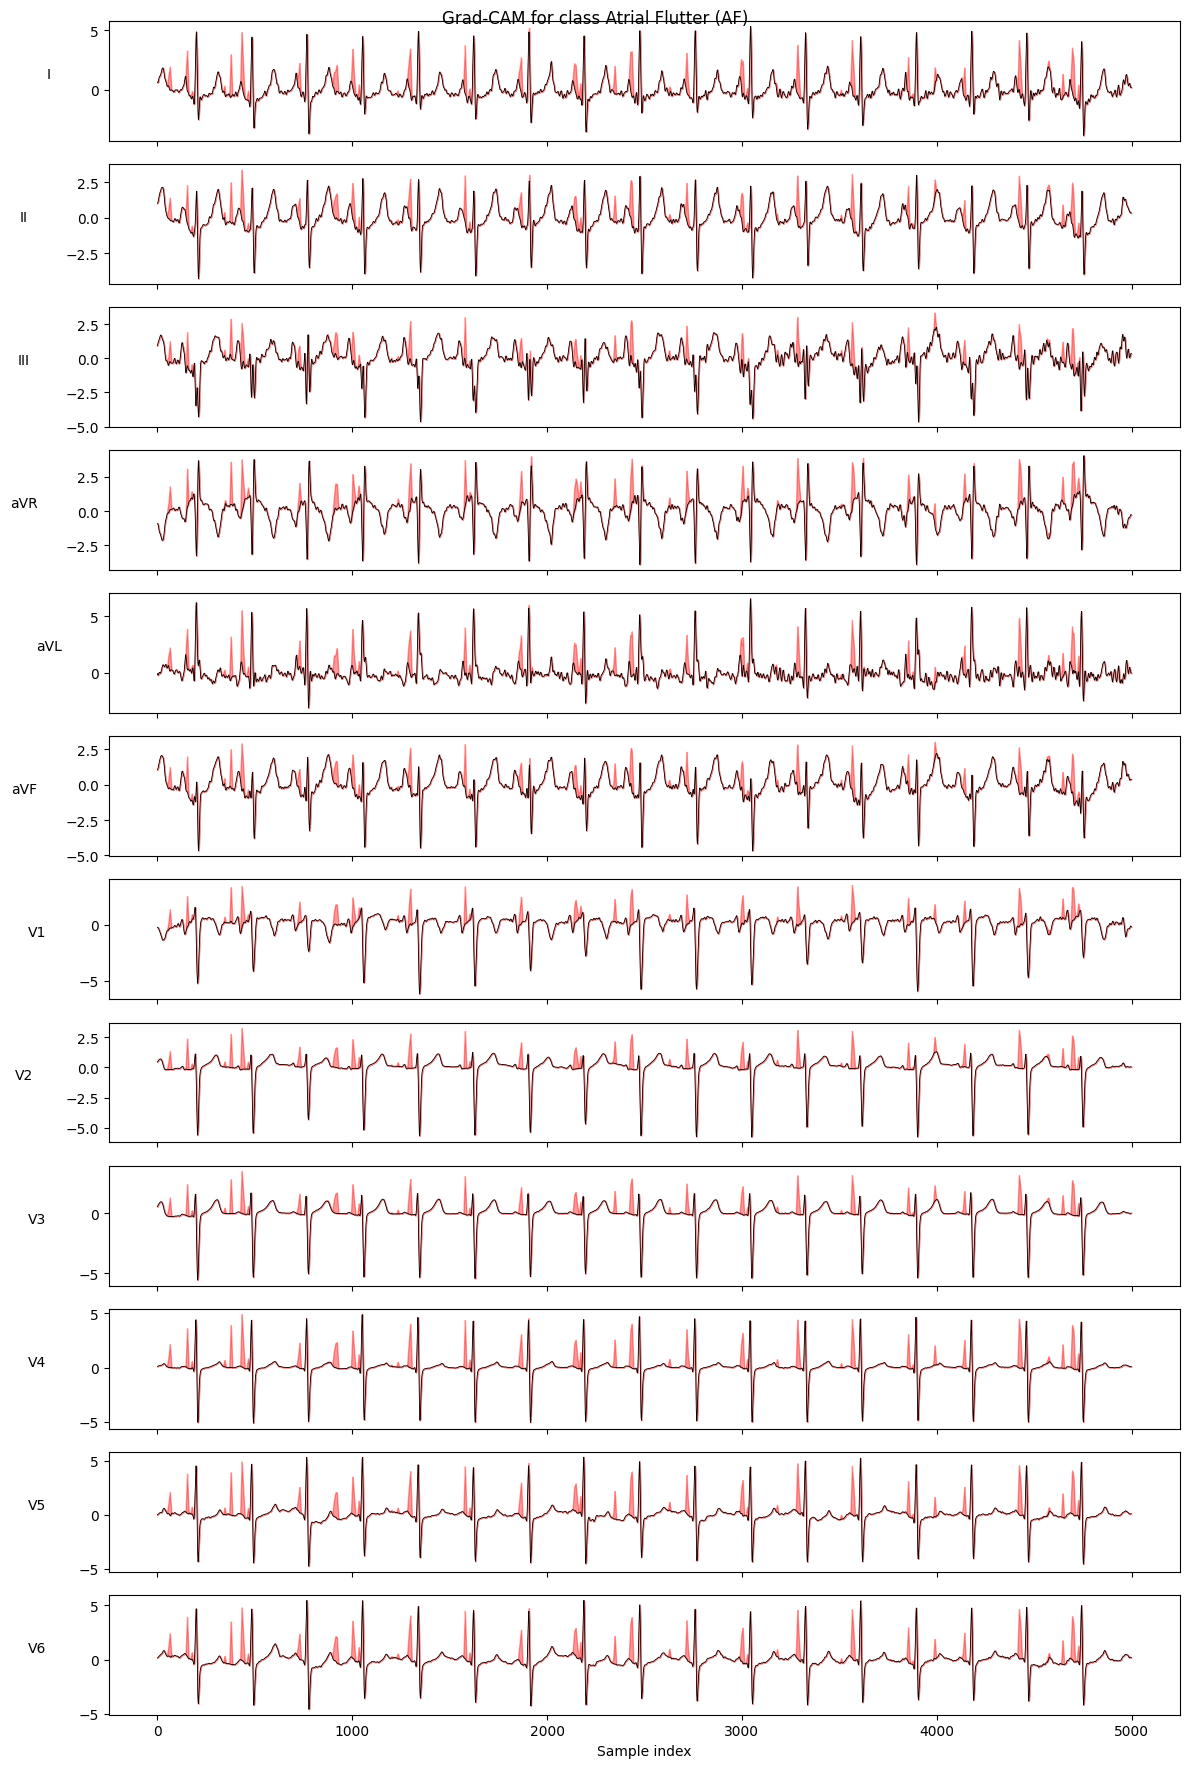

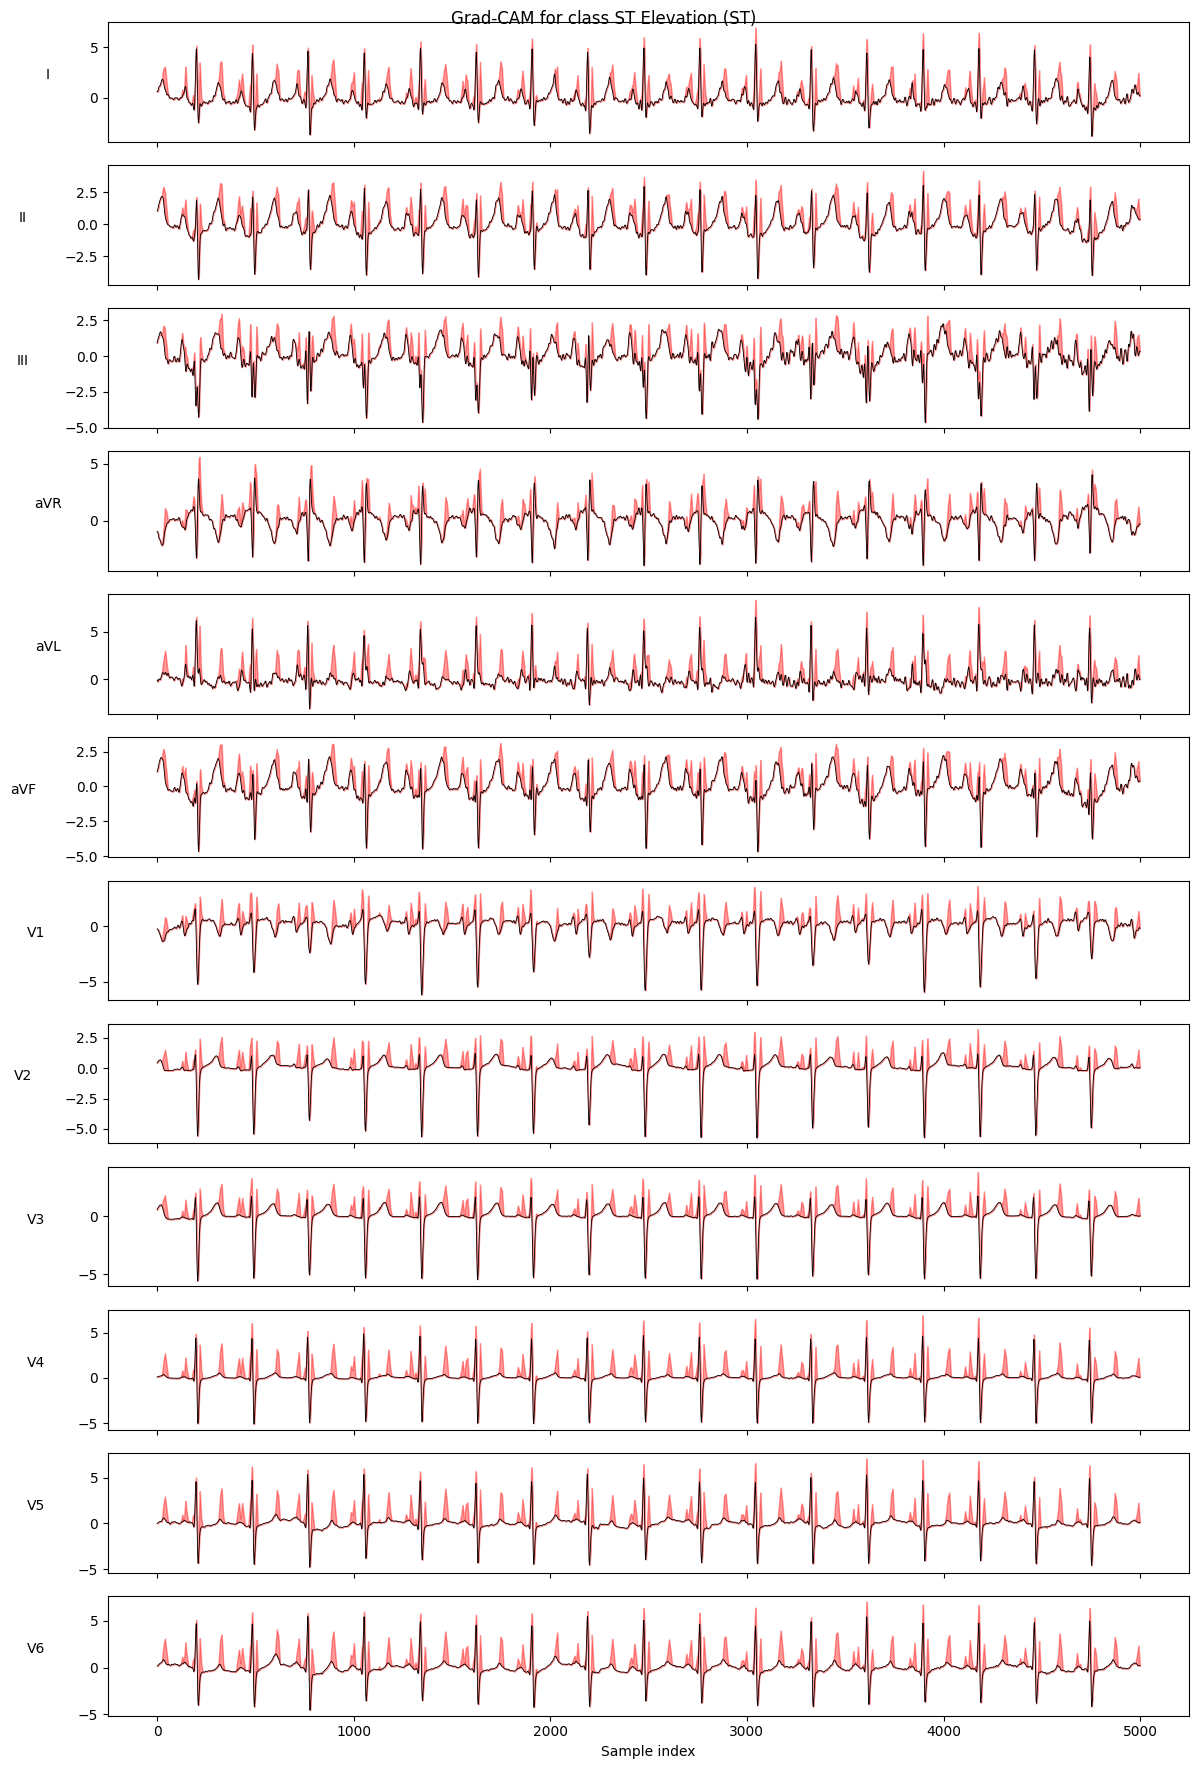

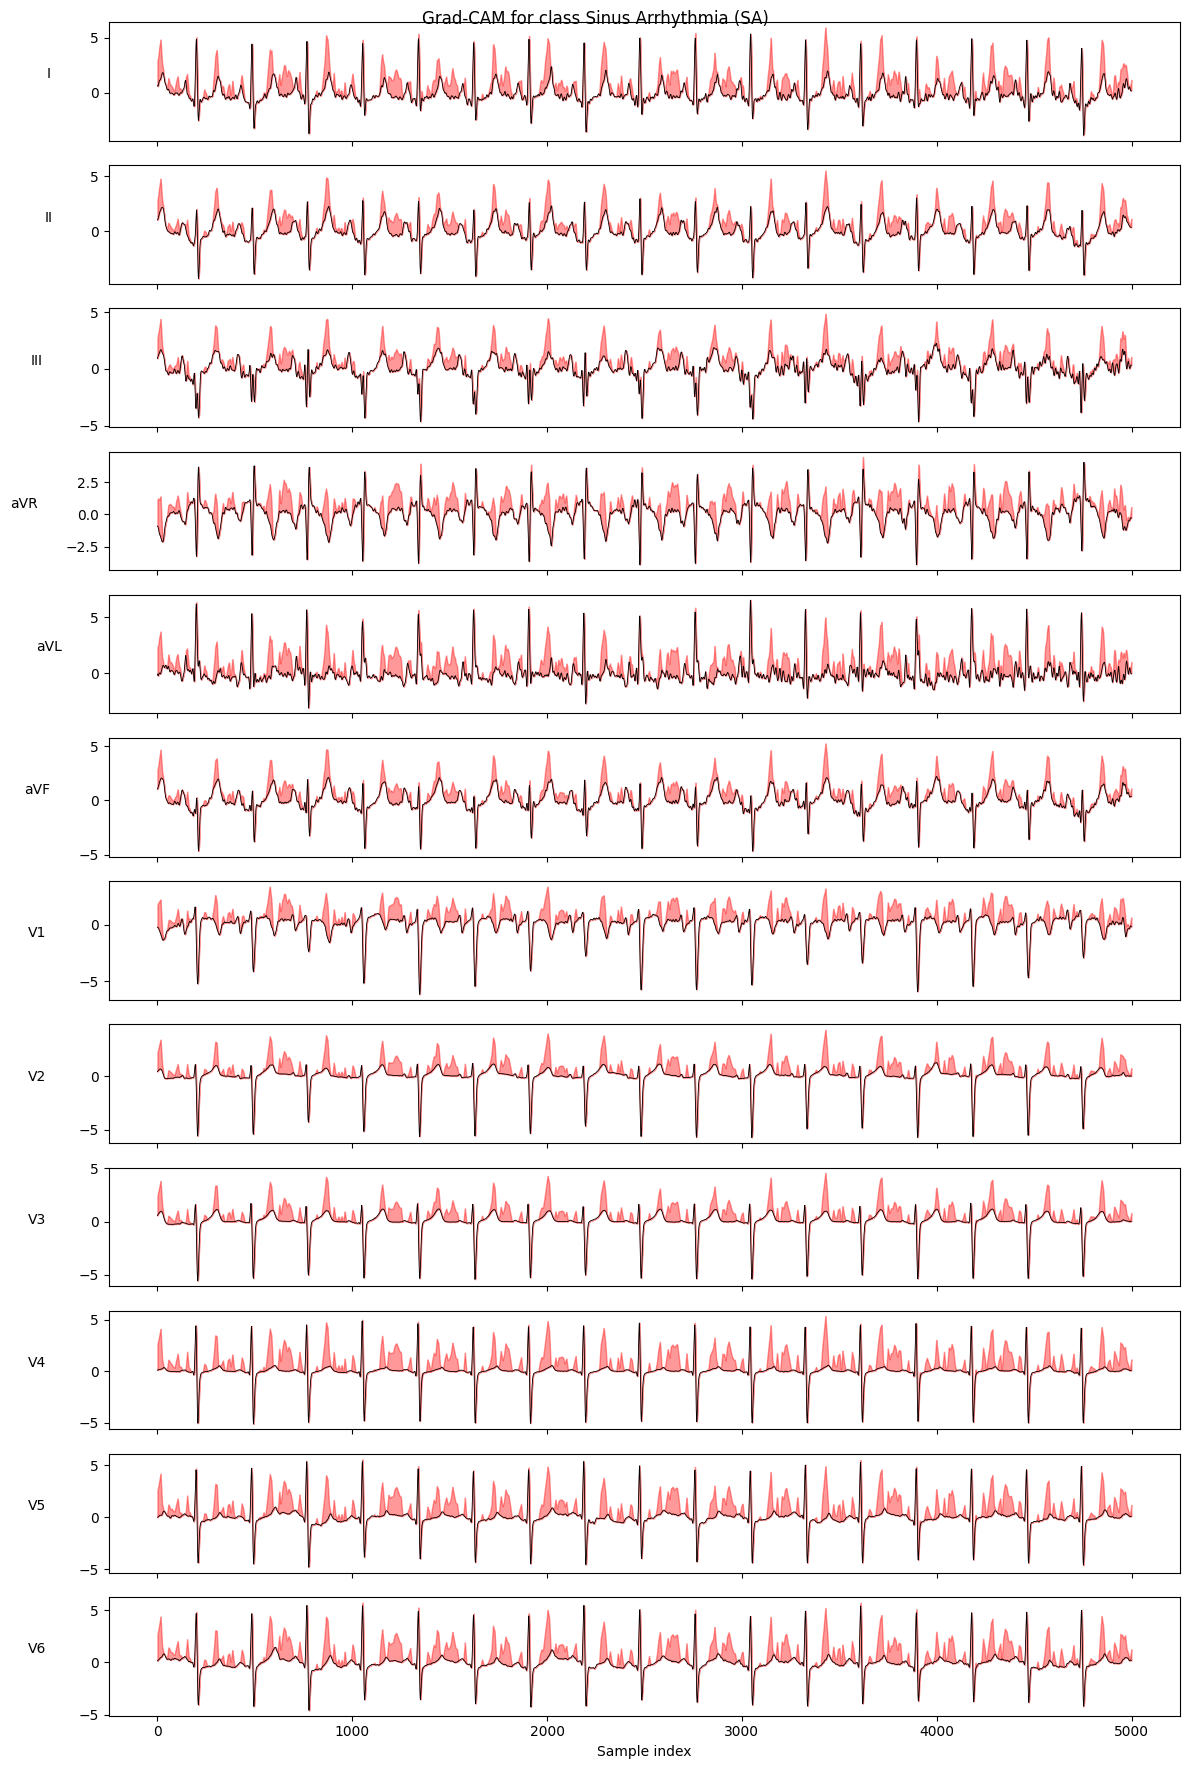

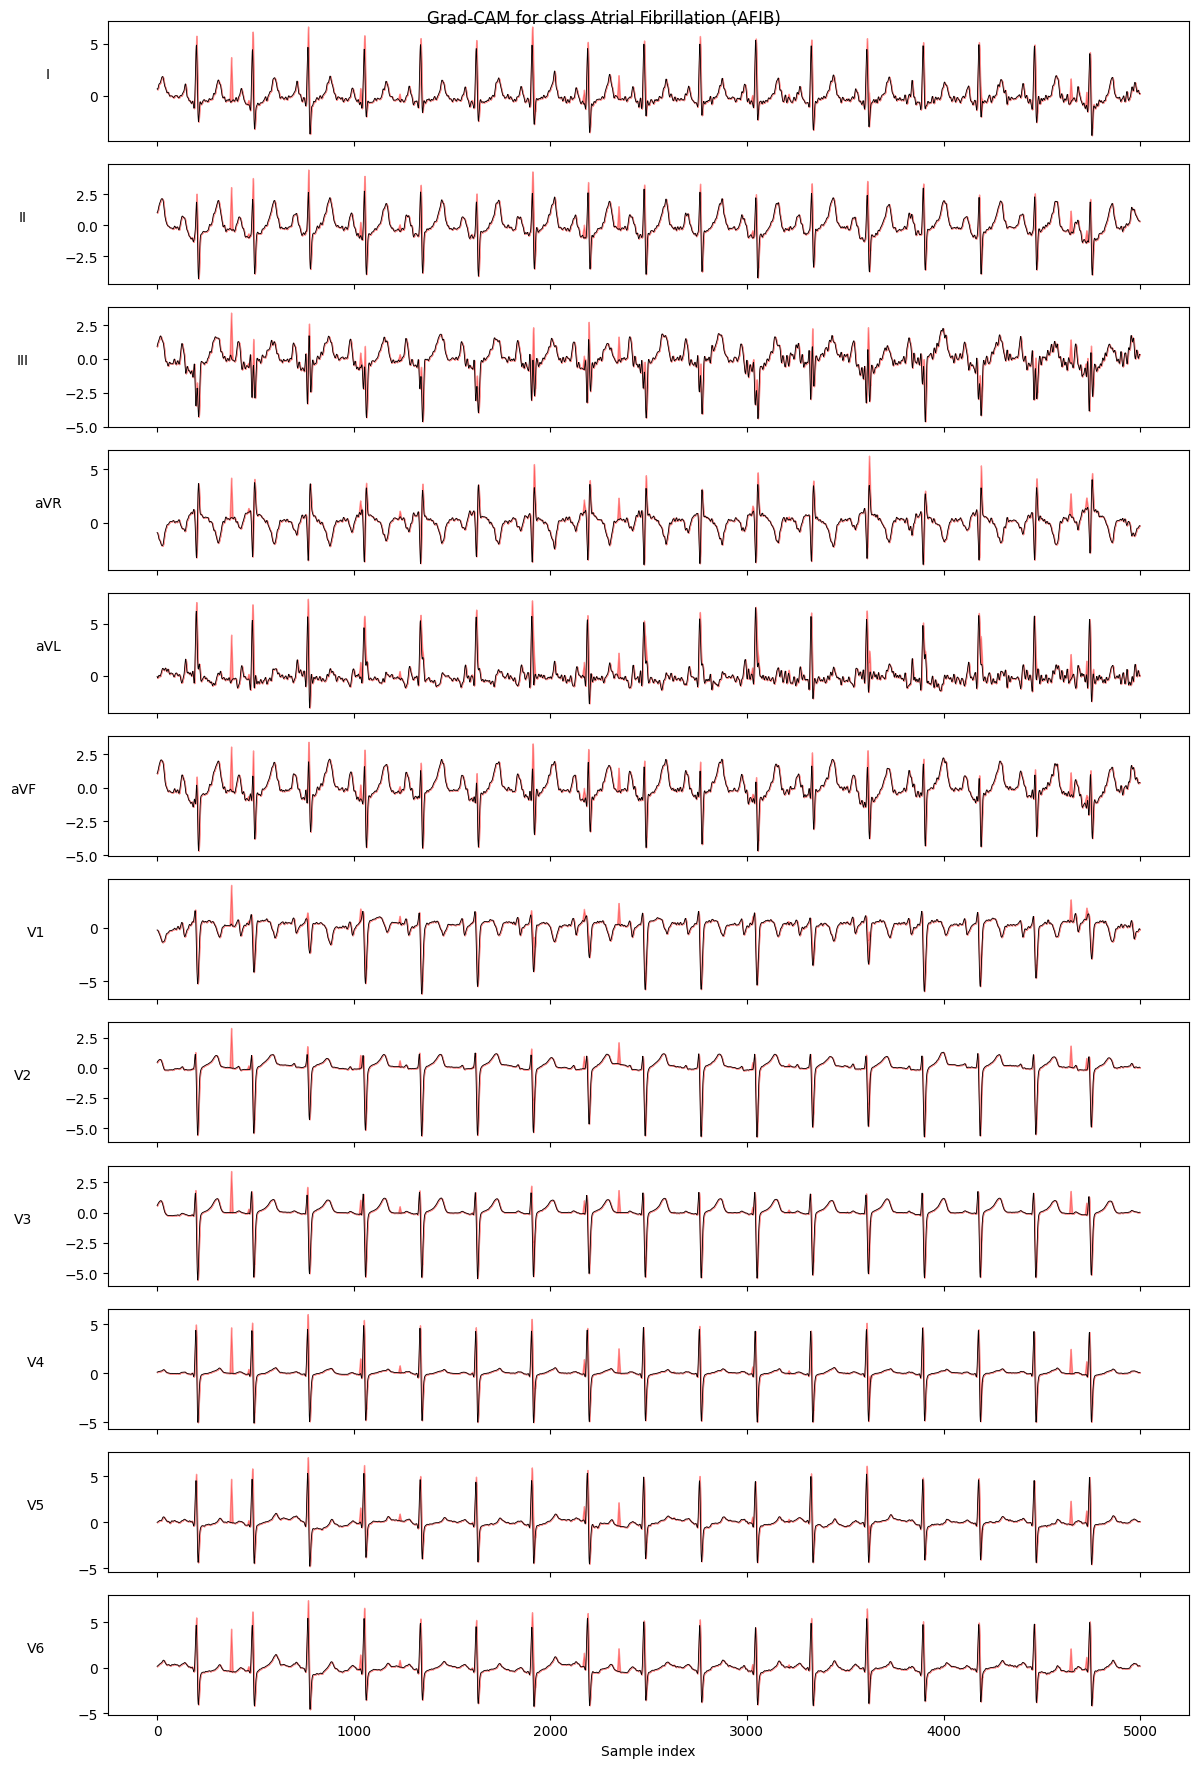

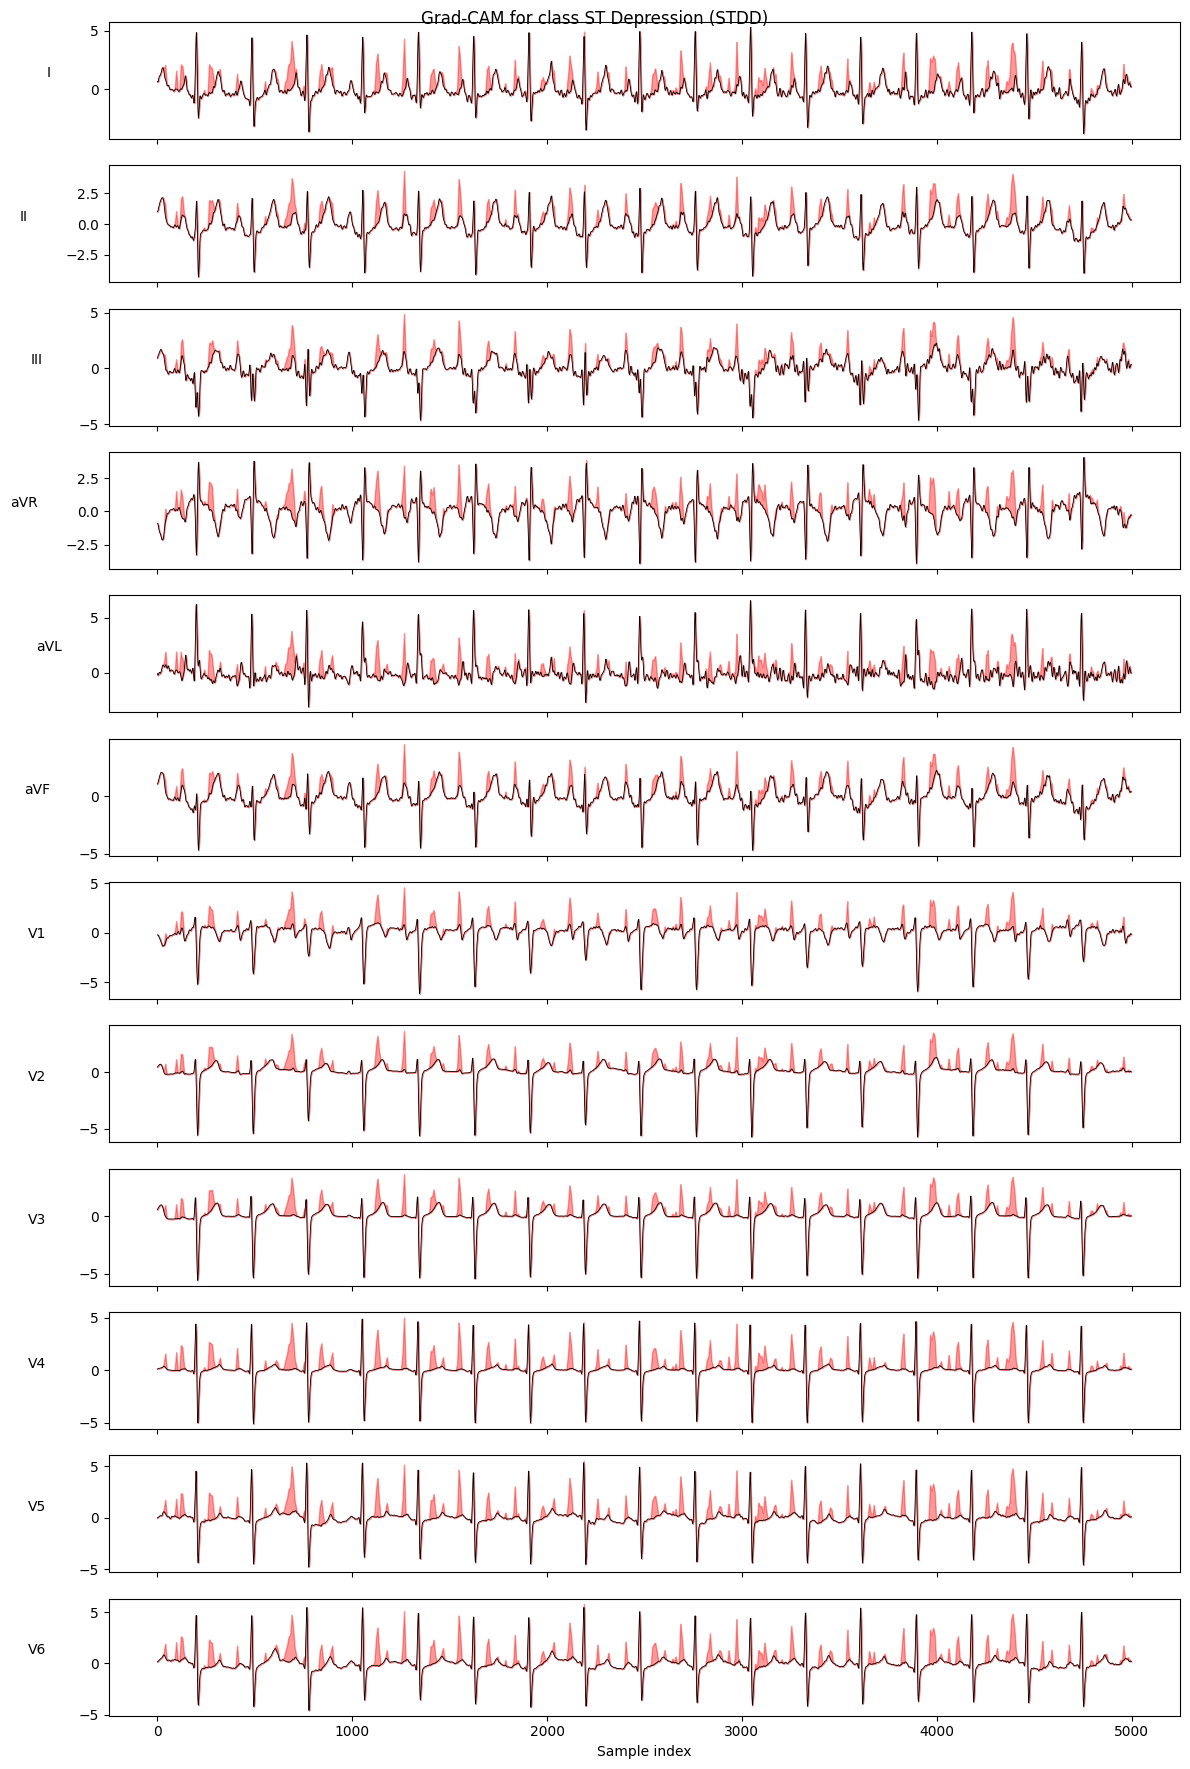

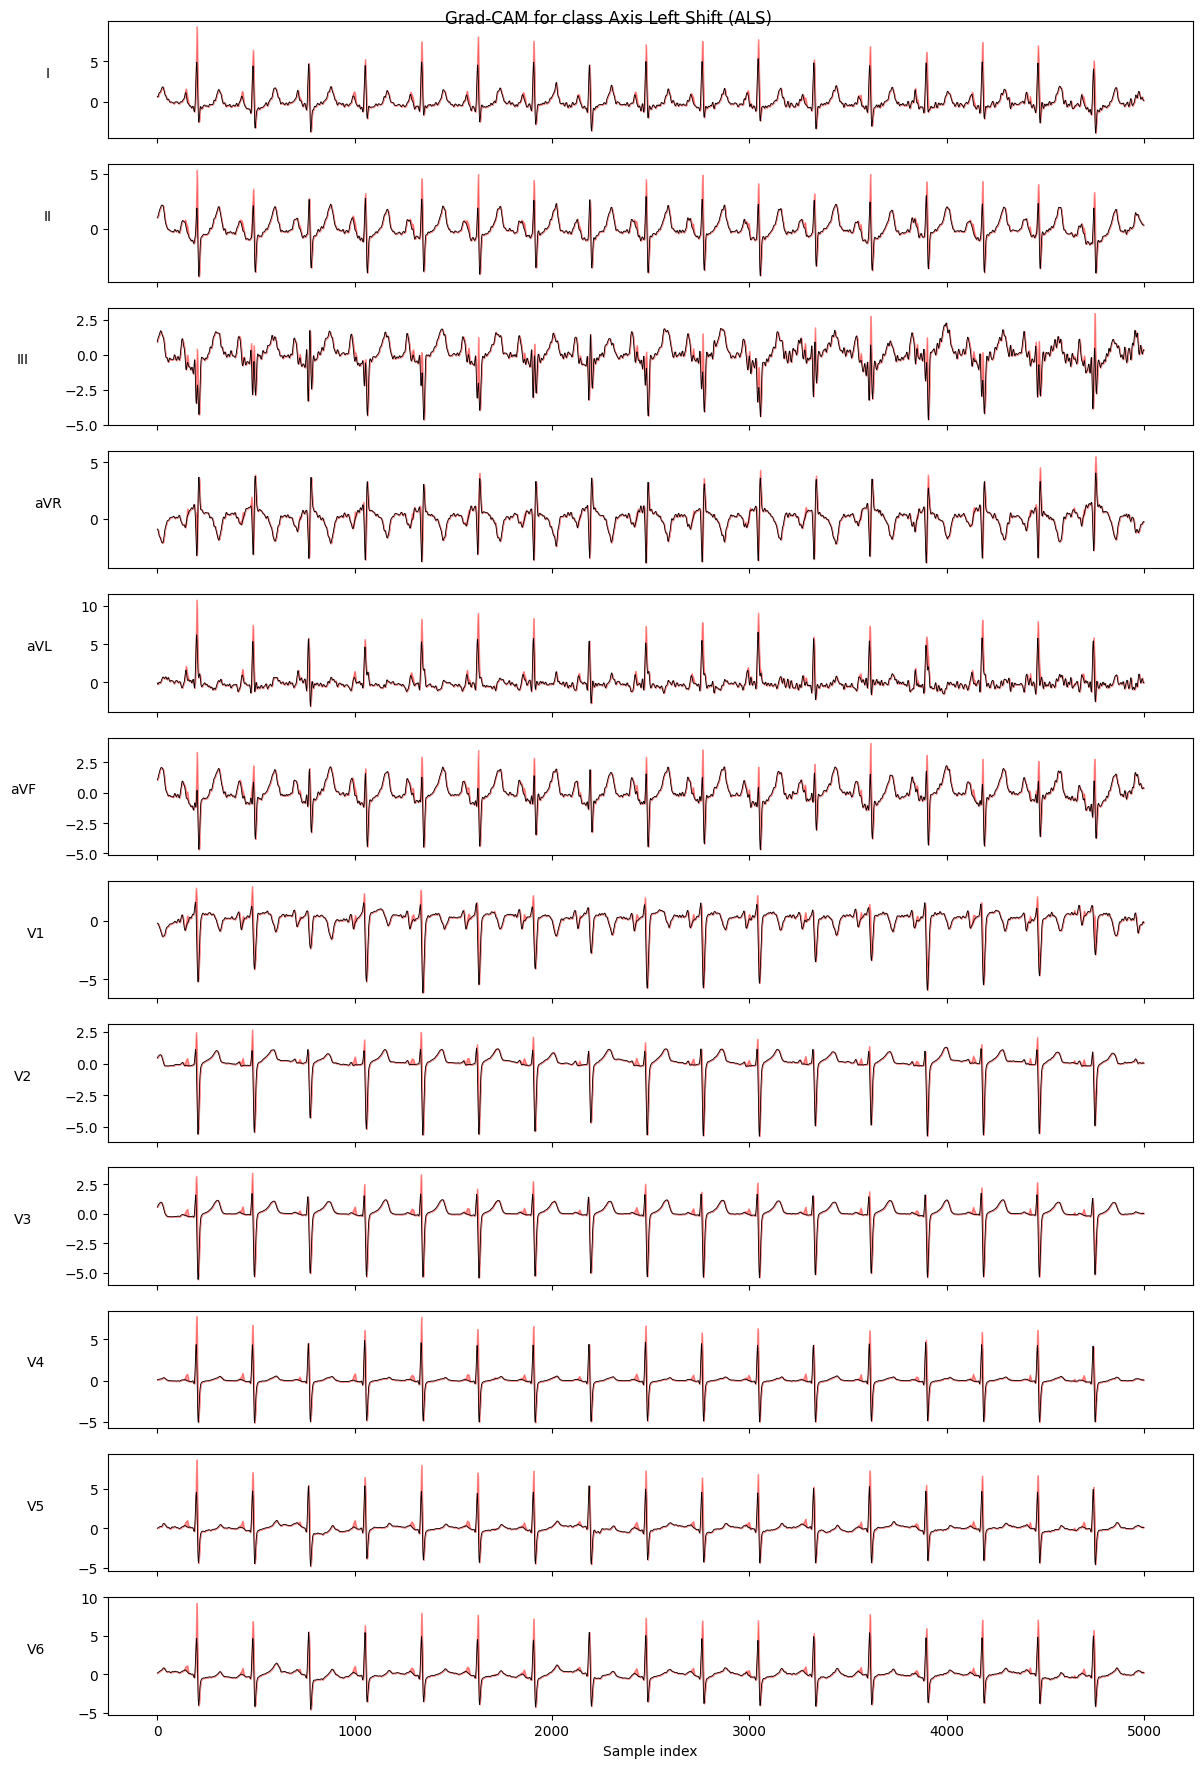

In [44]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- Grad-CAM 1D helper ---
class GradCam1D:
    def __init__(self, model, target_layer):
        """
        model: torch model
        target_layer: module (e.g. model.layer3)
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        # register hooks
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        # out shape: (batch, channels, seq_len_feat)
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out is a tuple; grad_out[0] shape: (batch, channels, seq_len_feat)
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, target_class):
        """
        input_tensor: torch.Tensor shape (1, channels=12, seq_len)
        target_class: int index of the class (0..num_classes-1)
        returns: heatmap_upsampled: numpy array shape (seq_len,)
        """
        self.model.eval()
        # ensure grads are zeroed
        self.model.zero_grad()

        # forward pass
        input_tensor = input_tensor.to(next(self.model.parameters()).device)
        outputs = self.model(input_tensor)             # logits shape (1, num_classes)
        # take the scalar logit for target_class
        score = outputs[0, target_class]
        # backward on that score
        score.backward(retain_graph=True)

        # activations (1, C, L_feat), gradients (1, C, L_feat)
        activations = self.activations.cpu().numpy()[0]   # (C, Lf)
        gradients = self.gradients.cpu().numpy()[0]       # (C, Lf)

        # global-average-pool gradients over time axis -> weights per channel
        weights = np.mean(gradients, axis=1)              # (C,)

        # weighted sum of activations
        cam = np.zeros(activations.shape[1], dtype=np.float32)  # (Lf,)
        for i, w in enumerate(weights):
            cam += w * activations[i, :]

        # relu
        cam = np.maximum(cam, 0)

        # normalize cam to [0,1]
        if cam.max() > 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)

        # upsample from feature length Lf -> original seq_len
        # infer original seq_len from input tensor
        seq_len = input_tensor.shape[-1]
        Lf = cam.shape[0]
        # create coordinates and interpolate with numpy.interp
        xp = np.linspace(0, seq_len - 1, num=Lf)
        x = np.arange(seq_len)
        cam_upsampled = np.interp(x, xp, cam)  # shape (seq_len,)

        return cam_upsampled  # numpy array

# --- Example usage ---
# 1) Load model and create GradCam1D instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet1DAttention(num_classes=8)
model.load_state_dict(torch.load("resnet_attention_best_fold.pth", map_location=device))
model.to(device)
model.eval()

# target_layer: layer before permute and attention -> model.layer3
gc = GradCam1D(model, model.layer3)

# 2) pick a sample from dataset (single sample)
# Suppose test_dataset is your ECGDataset and you want index idx
idx = 0
signal_tensor, label = test_dataset[idx]
# Ensure shape (1, channels, seq_len)
input_tensor = signal_tensor.unsqueeze(0)  # (1, 12, seq_len)

# Duyệt qua tất cả class
for class_i in range(num_classes):
    heatmap = gc.generate(input_tensor, target_class=class_i)  # (seq_len,)

    sig = input_tensor.squeeze(0).cpu().numpy()  # (12, seq_len)
    t = np.arange(sig.shape[1])

    fig, axes = plt.subplots(12, 1, figsize=(12, 18), sharex=True)
    for lead in range(12):
        axes[lead].plot(t, sig[lead], linewidth=0.6, color='black')
        hm = heatmap * (np.max(sig[lead]) - np.min(sig[lead])) * 0.5
        axes[lead].fill_between(t, sig[lead], sig[lead] + hm, alpha=0.4, color='red')
        axes[lead].set_ylabel(lead_names[lead], rotation=0, labelpad=30, fontsize=10, loc='center')
    axes[-1].set_xlabel("Sample index")
    plt.suptitle(f"Grad-CAM for class {class_names[class_i]}")
    plt.tight_layout()
    plt.show()

# **BINS**

> - **FINETUNING**

> TÍNH LẠI POSWEIGHT 

In [45]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# y_train: numpy array (samples, num_classes)
pos_weight = []
for i in range(y_train.shape[1]):
    w = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train[:, i])
    pos_weight.append(w[1])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [46]:
# Load lại mô hình tốt nhất
model = ResNet1DAttention(num_classes=8)
model.load_state_dict(torch.load("resnet_attention_best_fold.pth"))
model.to(device)

# Gán lại optimizer và criterion mới có pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)  # nhỏ hơn để fine-tune

# Fine-tune thêm vài epoch
model.train()
for epoch in range(10):
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Fine-tune epoch {epoch+1}, loss = {total_loss / len(train_loader):.4f}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24916\1485766056.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_attention_best_fold.

Fine-tune epoch 1, loss = 0.3120
Fine-tune epoch 2, loss = 0.3041
Fine-tune epoch 3, loss = 0.3016
Fine-tune epoch 4, loss = 0.2997
Fine-tune epoch 5, loss = 0.2969
Fine-tune epoch 6, loss = 0.2948
Fine-tune epoch 7, loss = 0.2930
Fine-tune epoch 8, loss = 0.2920
Fine-tune epoch 9, loss = 0.2904
Fine-tune epoch 10, loss = 0.2885


- **ĐÁNH GIÁ LẠI TRÊN TEST SET**

In [47]:
evaluate_model(model, test_loader, y_test, device=device)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3267
           1       0.59      0.79      0.68      1610
           2       0.73      0.94      0.82      1630
           3       0.83      0.94      0.89      1469
           4       0.21      0.53      0.30       482
           5       0.22      0.79      0.34       376
           6       0.28      0.79      0.41       336
           7       0.48      0.89      0.63       323

   micro avg       0.63      0.88      0.73      9493
   macro avg       0.53      0.83      0.62      9493
weighted avg       0.72      0.88      0.78      9493
 samples avg       0.69      0.88      0.75      9493


Confusion Matrices:
Label 0:
[[5285  289]
 [ 176 3091]]

Label 1:
[[6360  871]
 [ 333 1277]]

Label 2:
[[6645  566]
 [  91 1539]]

Label 3:
[[7095  277]
 [  82 1387]]

Label 4:
[[7374  985]
 [ 228  254]]

Label 5:
[[7411 1054]
 [  80  296]]

Label 6:
[[7822  683]
 [  72

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], shape=(8841, 8)),
 array([[1.05488894e-03, 4.99439150e-01, 1.65292622e-05, ...,
         1.84417627e-06, 1.42912474e-03, 3.02516341e-01],
        [6.39311111e-05, 7.69390464e-02, 8.97354901e-01, ...,
         5.75367212e-01, 5.21233352e-03, 5.43039334e-07],
        [8.78503919e-01, 3.80886436e-01, 8.52156151e-03, ...,
         2.02942304e-02, 5.13218082e-02, 2.75440556e-07],
        ...,
        [1.02289821e-08, 8.32933962e-01, 2.86325277e-03, ...,
         5.15138381e-05, 2.05572154e-02, 3.14539332e-15],
        [9.71620142e-01, 5.29098175e-02, 6.38101529e-03, ...,
         6.95785275e-03, 2.92891291e-05, 5.59140751e-08],
        [9.95534539e-01, 2.03029998e-02, 1.16709225e-05, ...,
         8.45008981e-06, 1.15248584e-03, 1.31566054e-07]],
       shape=(8841, 8), dtype=float3

In [ ]:
# Lưu lại mô hình fine-tuned
torch.save(model.state_dict(), "resnet_attention_finetuned_posweight_2.pth")